<center>
<h1 style="font-family:verdana">
 💻 🧑 Reconeixement d'entitats anomenades 🧑 💻


<p> 🎯 <b>Objectiu</b>: en aquesta segona part de la pràctica aprendrem a reconèixer entitats anomenades, és a dir, identificar i classificar entitats en una oració que poden ser (en el context de reserva de vols) la ciutat de sortida o d'arribada, la data del mes i el dia, si es de negocis o turista o altres categories específiques. Aquesta tasca se sol plantejar etiquetant cada paraula amb una etiqueta de la categoria de l'entitat a la qual correspon.

Tant la classificació d'intencions (tasca estudiada a la primera part) com el reconeixement d'entitats anomenades (Name Entity Recognition, NER) que veurem en aquesta part són components crucials dels sistemes de processament del llenguatge natural (Natural Language Processing, NLP) i sovint s'utilitzen junts per crear aplicacions d'intel·ligència artificial (IA) conversacionals més sofisticades. Per exemple, en un xatbot, la classificació d'intencions ajuda a entendre la intenció principal de l'usuari, mentre que el reconeixement d'entitats anomenades ajuda a extreure entitats rellevants per proporcionar respostes més contextualitzades.


<p> ✨ <b>Contingut</b>: els passos d'aquesta segona part seran similars a la primera. En primer lloc, analitzarem el conjunt de dades. En segon lloc, prepararem les dades per a poder entrenar el model. I finalment dissenyarem l'arquitectura i entrenarem el model. </p>


<p> ✏ <b>Exercicis</b>: en cada secció anireu trobant exercicis que haureu d'anar resolent. </p>

---

<h2> Índex </h2>

1. [Inspecció del conjunt de dades](#section-one)
  * [Exercici 1](#ex-one)
  * [Exercici 2](#ex-two)
2. [Preprocessament de dades](#section-two)
  * [Exercici 3](#ex-three)
  * [Exercici 4](#ex-four)
3. [Disseny del model i entrenament](#section-three)
  * [Exercici 5](#ex-five)
  * [Exercici 6](#ex-six)
4. [Lliurable](#section-four)

---

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report


In [2]:
from keras.utils import set_random_seed
set_random_seed(1)

<h1><a name="section-one"> 1. Inspecció del conjunt de dades </a></h1>

In [3]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t"
!tar -zxf nlu_ATIS_data.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1u2wzXvsuscLeFHwXcDwMDaNDy0u_99-t
To: /content/nlu_ATIS_data.tar.gz
100% 122k/122k [00:00<00:00, 21.5MB/s]


In [4]:
!ls data

test.csv  train.csv


En aquesta segona part de la pràctica utilitzarem el mateix dataset que a la primera part, però en aquest cas utilitzarem la **primera columna** que correspon a les **oracions** introduïdes pels usuaris i la **segona columna** on trobarem les oracions d'entrada en format **BILOU**.

El format BILOU  és un esquema d'etiquetatge que es fa servir a les tasques de reconeixement d'entitats anomenades. El nom *BILOU* representa les etiquetes utilitzades en aquest esquema:

*   **B** - Beginning: primer token d'una entitat.
*   **I** - Inside: token dins d'una entitat.
*   **L** - Last: últim token de l'entitat.
*   **O** - Outside: token que no pertany a cap entitat.
*   **U** - Unit: entitats d'un sol token

A continuació, carregarem les dades per visualitzar i poder entendre millor aquestes etiquetes.

---

 <h1><a name="ex-one"><center> ✏ Exercici 1 ✏</a></h1>

A continuació us demanem que carregueu els dos CSVs de la carpeta `data`: `train.csv`, `test.csv` utilitzant pandas. Recorda que aquests CSVs no tenen capçalera. Agafeu les 900 últimes lineas del fitxer `train.csv` per crear un dataframe per validació.

In [5]:
#TODO
train_data = pd.read_csv('./data/train.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('./data/train.csv', header=None, nrows=4078)
test_data = pd.read_csv('./data/test.csv', header=None)

print('Training size:', len(train_data))
print('Validation dataset size:', len(val_data))
print('Test dataset size:', len(test_data))

Training size: 4078
Validation dataset size: 900
Test dataset size: 893


In [6]:
test_data

,0,1,2
0,i would like to find a flight from charlotte t...,"""O O O O O O O O B-fromloc.city_name O B-tolo...","""flight"""
1,on april first i need a ticket from tacoma to ...,"""O B-depart_date.month_name B-depart_date.day...","""airfare"""
2,on april first i need a flight going from phoe...,"""O B-depart_date.month_name B-depart_date.day...","""flight"""
3,i would like a flight traveling one way from p...,"""O O O O O O B-round_trip I-round_trip O B-fr...","""flight"""
4,i would like a flight from orlando to salt lak...,"""O O O O O O B-fromloc.city_name O B-toloc.ci...","""flight"""
...,...,...,...
888,please find all the flights from cincinnati to...,"""O O O O O O B-fromloc.city_name O O O O O B-...","""flight"""
889,find me a flight from cincinnati to any airpor...,"""O O O O O B-fromloc.city_name O O O O O B-to...","""flight"""
890,i 'd like to fly from miami to chicago on amer...,"""O O O O O O B-fromloc.city_name O B-toloc.ci...","""flight"""
891,i would like to book a round trip flight from ...,"""O O O O O O B-round_trip I-round_trip O O B-...","""flight"""


---

 <h1><a name="ex-two"><center> ✏ Exercici 2 ✏</a></h1>

Tal com hem introduït abans, per a aquest exercici ens centrarem en la **primera** i la **segona** columna. Per tant, ara us demanem que guardeu en les següents variables, les llistes corresponents a les oracions i a les etiquetes de les tres particions (`train`, `validation` i `test`).

In [7]:
#TODO
train_sentences = list(train_data[0])
train_labels = list(s.replace('"', '') for s in train_data[1])

val_sentences = list(val_data[0])
val_labels = list(s.replace('"', '') for s in val_data[1])

test_sentences = list(test_data[0])
test_labels = list(s.replace('"', '') for s in test_data[1])

---

Si tot ha anat bé ja podem analitzar quin aspecte té el format BILOU.

In [8]:
print(train_sentences[0])
print(train_labels[0])

i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
 O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day


Aquest hauria de ser el resultat obtingut si executeu la cel·la anterior:

```


i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
 "O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day"


```

En aquest exemple, `boston` i `838 am` corresponen a l'entitat "ciutat de sortida" i a l'entitat "hora de sortida" respectivament (`fromloc.city_name`,`depart_time.time`). `838` correspon al primer token que pertany la entitat `depart_time.time` i `am` al segon de la mateixa entitat. Els tokens com `i` o `want` no pertanyen a cap entitat.

In [9]:
print(train_sentences[1])
print(train_labels[1])

what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day


I aquest hauria de ser el resultat de la cel·la anterior:

```
what flights are available from pittsburgh to baltimore on thursday morning
 O O O O O B-fromloc.city_name O B-toloc.city_name O B-depart_date.day_name B-depart_time.period_of_day
```

En l'anterior exemple, `what`, `flights`, `are`, `available`, `from`, `to` i `on` estan etiquetades com a no pertanyents a cap entitat. I, en canvi, `pittsburgh` pertany a l'entitat d'un sol token anomenada ciutat d'arribada (`toloc.city_name`). També hi ha entitats compostes com `baltimore` que pertany a l'entitat ciutat de sortida (`fromloc.city_name`) i `thursday morning` que pertanyen a les entitats data de sortida (`depart_date.day_name`, `depart_time.period_of_day`).

Vegem-ne la llista completa d'entitats.

In [10]:
from collections import Counter

def count_unique_entities(list_of_label_sentences):
  flat_labels = []
  for labels in list_of_label_sentences:
    flat_labels += labels.split()
  c = Counter(flat_labels)
  return len(c), list(c.keys())

num_unique_entities, unique_entities = count_unique_entities(train_labels)

print("Number of different entities:", num_unique_entities)

print("Unique entities:", unique_entities)

Number of different entities: 119
Unique entities: ['O', 'B-fromloc.city_name', 'B-depart_time.time', 'I-depart_time.time', 'B-toloc.city_name', 'B-arrive_time.time', 'B-arrive_time.period_of_day', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-flight_time', 'I-flight_time', 'I-fromloc.city_name', 'B-cost_relative', 'B-round_trip', 'I-round_trip', 'B-fare_amount', 'I-fare_amount', 'B-depart_date.today_relative', 'I-toloc.city_name', 'B-city_name', 'B-stoploc.city_name', 'B-toloc.airport_code', 'B-depart_time.time_relative', 'B-class_type', 'I-class_type', 'B-depart_date.date_relative', 'B-airline_name', 'I-airline_name', 'B-arrive_time.time_relative', 'B-depart_time.start_time', 'I-depart_time.start_time', 'B-depart_time.end_time', 'I-depart_time.end_time', 'B-fromloc.airport_name', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-depart_date.day_number', 'I-depart_date.day_number', 'B-depart_date.month_name', 'B-mod', 'B-fare_basis_code', 'B-transport_type', 'B-flight_m

<h1><a name="section-two"> 2. Preprocessament de dades </a></h1>

El processament de les dades serà semblant al de la primera part d'aquesta pràctica.

---

 <h1><a name="ex-three"><center> ✏ Exercici 3 ✏</a></h1>

En aquest exercici us demanem que realitzeu els passos següents per preparar les dades.

 1. El primer pas serà construir el vocabulari a partir de les paraules presents a les oracions d'entrenament.

2. El segon pas serà convertir les oracions en seqüències de nombres enters usant el tokenitzador.

3. El tercer pas serà guardar la longitud original de cada oració. Això ens serà útil per evaluar el nostre model sense tenir en compte el padding.

3. Finalment, per aconseguir que totes les seqüències tinguen la mateixa longitud, fixarem la longitud segons la màxima trobada a l'entrenament i afegirem zeros a les oracions de menor longitud.

Recordeu que podeu consultar com fer-ho a la documentació de la llibrería:
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer"> Tokenizer </a>
* <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences"> Pad Sequences </a>




In [11]:
num_words=1000
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(train_sentences)

vocab = tokenizer.word_index
print(vocab)
print(len(vocab))

{'to': 1, 'from': 2, 'flights': 3, 'the': 4, 'on': 5, 'what': 6, 'me': 7, 'flight': 8, 'boston': 9, 'show': 10, 'san': 11, 'i': 12, 'denver': 13, 'a': 14, 'francisco': 15, 'in': 16, 'and': 17, 'atlanta': 18, 'pittsburgh': 19, 'is': 20, 'dallas': 21, 'baltimore': 22, 'all': 23, 'philadelphia': 24, 'like': 25, 'are': 26, 'list': 27, 'airlines': 28, 'of': 29, 'between': 30, 'that': 31, 'washington': 32, 'leaving': 33, 'please': 34, 'pm': 35, 'morning': 36, 'would': 37, 'fly': 38, 'for': 39, 'fare': 40, 'first': 41, 'wednesday': 42, 'after': 43, 'there': 44, 'oakland': 45, "'d": 46, 'ground': 47, 'you': 48, 'does': 49, 'trip': 50, 'transportation': 51, 'class': 52, 'arriving': 53, 'cheapest': 54, 'need': 55, 'city': 56, 'round': 57, 'with': 58, 'before': 59, 'which': 60, 'available': 61, 'have': 62, 'give': 63, 'at': 64, 'fares': 65, 'american': 66, 'afternoon': 67, 'one': 68, 'want': 69, 'how': 70, 'way': 71, 'new': 72, 'dc': 73, 'nonstop': 74, 'arrive': 75, 'earliest': 76, 'york': 77, 'g

In [12]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
len_train_sequences = [len(seq) for seq in train_sequences]
max_sequence_length = max(map(len, train_sequences))
train_pad_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding = 'post')

val_sequences = tokenizer.texts_to_sequences(val_sentences)
len_val_sequences = [len(seq) for seq in val_sequences]
val_pad_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length, padding = 'post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
len_test_sequences = [len(seq) for seq in test_sequences]
test_pad_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding = 'post')

In [13]:
train_pad_sequences[0]

array([ 12,  69,   1,  38,   2,   9,  64, 415,  84,  17,  75,  16,  13,
        64, 493,  16,   4,  36,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)


---



In [14]:
train_sentences[0]

'i want to fly from boston at 838 am and arrive in denver at 1110 in the morning'

---

 <h1><a name="ex-four"><center> ✏ Exercici 4 ✏</a></h1>

Per aconseguir-ho haureu de seguir els passos següents.

 1. En primer lloc, haureu d'esbrinar quantes etiquetes diferents hi ha. Podeu prendre com a exemple la funció `count_unique_entities` per fer-ho. Tingueu en compte que haureu de modificar la funció, ja que per exemple aquesta funció considera que `B-depart_time.time`, `I-depart_time.time`, `L-depart_time.time`, `U-depart_time.time` són la mateixa entitat. En aquest exercici, necessitarem comptar-les per separat. També l'entitat O ha de ser considerada com una classe.

 2. El segon pas serà codificar les diferents classes trobades en etiquetes numèriques. Tingueu en compte que cada paraula de l'oració té una etiqueta i, per tant, per a cada oració tindrem una llista d'etiquetes. El *padding* el codificarem amb l'etiqueta corresponent a **O** (outside). Per ajudar-vos hem preparat el processament per a les etiquetes d'entrenament, intenteu comprendre el que es fa i així repetir-ho per a la partició de validació i test.

 3. Finalment, haureu de convertir les diferents classes a vectors one-hot. Recordeu de nou que per a cada oració tindrem una llista de vectors one-hot.


 Podeu consultar els apartats de la documentació:
 * <a href=https://www.tensorflow.org/guide/keras/understanding_masking_and_padding> Masking and Padding </a>

 * <a href=https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical> To Categorical </a>



In [15]:
#TODO
#Step 1
def count_unique_entities(list_of_label_sentences):
  flat_labels = []
  for labels in list_of_label_sentences:
    flat_labels += labels.split()
  c = Counter(flat_labels)
  return len(c), list(c.keys())

num_unique_entities, unique_entities = count_unique_entities(train_labels)

print("Number of different entities:", num_unique_entities)

print("Unique entities:", unique_entities)

#Step 2
label_encoder = LabelEncoder().fit(unique_entities)
train_numerical_labels = []
for seq_label in train_labels:
    encoded_labels = label_encoder.transform(seq_label.split())
    train_numerical_labels.append(encoded_labels)
train_pad_labels = pad_sequences(train_numerical_labels, maxlen=max_sequence_length, padding = 'post', value=label_encoder.transform(['O']))

def remove_sentences(list_labels, list_sequences):
  idx_to_remove = []
  labels_to_remove = []
  for idx, labels in enumerate(list_labels):
    for label in labels:
      if label not in unique_entities:
        idx_to_remove.append(idx)
        labels_to_remove.append(label)

  labels = [elem for i, elem in enumerate(list_labels) if i not in idx_to_remove]
  sequences = [elem for i, elem in enumerate(list_sequences) if i not in idx_to_remove]
  print('Labels_to_remove: ', labels_to_remove)
  return labels, np.array(sequences)

Number of different entities: 119
Unique entities: ['O', 'B-fromloc.city_name', 'B-depart_time.time', 'I-depart_time.time', 'B-toloc.city_name', 'B-arrive_time.time', 'B-arrive_time.period_of_day', 'B-depart_date.day_name', 'B-depart_time.period_of_day', 'B-flight_time', 'I-flight_time', 'I-fromloc.city_name', 'B-cost_relative', 'B-round_trip', 'I-round_trip', 'B-fare_amount', 'I-fare_amount', 'B-depart_date.today_relative', 'I-toloc.city_name', 'B-city_name', 'B-stoploc.city_name', 'B-toloc.airport_code', 'B-depart_time.time_relative', 'B-class_type', 'I-class_type', 'B-depart_date.date_relative', 'B-airline_name', 'I-airline_name', 'B-arrive_time.time_relative', 'B-depart_time.start_time', 'I-depart_time.start_time', 'B-depart_time.end_time', 'I-depart_time.end_time', 'B-fromloc.airport_name', 'I-fromloc.airport_name', 'B-toloc.state_name', 'B-depart_date.day_number', 'I-depart_date.day_number', 'B-depart_date.month_name', 'B-mod', 'B-fare_basis_code', 'B-transport_type', 'B-flight_m

In [16]:
_test_labels = [label.split() for label in test_labels]
test_labels, test_pad_sequences = remove_sentences(_test_labels, test_pad_sequences)
test_numerical_labels = []
for seq_label in test_labels:
    encoded_labels = label_encoder.transform(seq_label)
    test_numerical_labels.append(encoded_labels)
test_pad_labels = pad_sequences(test_numerical_labels, maxlen=max_sequence_length, padding = 'post', value=label_encoder.transform(['O']))

_val_labels = [label.split() for label in val_labels]
val_labels, val_pad_sequences = remove_sentences(_val_labels, val_pad_sequences)
val_numerical_labels = []
for seq_label in val_labels:
    encoded_labels = label_encoder.transform(seq_label)
    val_numerical_labels.append(encoded_labels)
val_pad_labels = pad_sequences(val_numerical_labels, maxlen=max_sequence_length, padding = 'post', value=label_encoder.transform(['O']))


#Step 3
train_labels_one_hot = to_categorical(train_pad_labels, num_classes = num_unique_entities)
val_labels_one_hot = to_categorical(val_pad_labels, num_classes = num_unique_entities)
test_labels_one_hot = to_categorical(test_pad_labels, num_classes = num_unique_entities)

Labels_to_remove:  ['B-return_date.day_name', 'I-flight_number', 'B-compartment', 'B-stoploc.airport_code', 'I-state_name', 'B-return_date.day_name', 'B-booking_class', 'B-flight']
Labels_to_remove:  ['I-meal_description', 'B-return_date.today_relative', 'I-return_date.today_relative', 'I-return_date.today_relative', 'B-return_date.day_name']


<h1><a name="section-three"> 3. Disseny del model i entrenament </a></h1>

---
<h1><a name="ex-five"><center> ✏ Exercici 5 ✏</a></h1>

De forma similar com féreu a la primera part de la pràctica us demanem que dissenyeu l'arquitectura i entreneu el model. Podeu fer servir una arquitectura similar. Ara bé, per capturar les dependències seqüencials podeu canviar la capa de GlobalMaxPooling1D per una LSTM.

In [17]:
s = train_pad_labels.shape
train_flat_labels = train_pad_labels.reshape(s[0]*s[1]) #Una única llista, concat. de llista de labels
train_unq_labels = np.unique(train_flat_labels) #Llista de 0-118
print(train_flat_labels.shape, train_unq_labels)

(187588,) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]


In [18]:
#TODO
set_random_seed(1)
embedding_dim = 100
vocab_size = num_words + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model.add(LSTM(units=64, return_sequences=True))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_unique_entities, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 5
model.fit(train_pad_sequences, train_labels_one_hot, batch_size=batch_size, epochs=epochs, validation_data=(val_pad_sequences, val_labels_one_hot))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size)
print(f"Test accuracy: {accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8710 - loss: 1.7294 - val_accuracy: 0.9286 - val_loss: 0.3342
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9385 - loss: 0.2765 - val_accuracy: 0.9508 - val_loss: 0.2488
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9596 - loss: 0.1735 - val_accuracy: 0.9640 - val_loss: 0.2086
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9709 - loss: 0.1212 - val_accuracy: 0.9727 - val_loss: 0.1886
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9795 - loss: 0.0857 - val_accuracy: 0.9802 - val_loss: 0.1734
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9793 - loss: 0.1748
Test accuracy: 0.98


In [19]:
preds = model.predict(test_pad_sequences)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


In [20]:
preds.shape

(885, 46, 119)

In [18]:
def preds_to_index(preds, seq_lens):
  '''
  Turn predictions to numerical indexes, flatten the sentences and discard padding.
  '''
  idx_preds = []
  for pred, seq_len in zip(preds,seq_lens):
      for l in range(seq_len):
        idx_preds.append(np.argmax(pred[l]))
  return idx_preds

Com ja sabeu, NER es una tasca on les dades estan molt desbalancejades. La gran majoria de les nostres etiquetes serán 'O' (outside). Es pot donar el cas on el model tingui una accuracy molt alta predint sempre 'O'.

Per mesurar millor com de bó és el nostre model, calcularem la F1 score per cada classe, així com la mitjana (macro average). Quan prepareu el vostre document, heu de reportar aquesta mitjana com a mètrica del vostre model, no l'acuracy.

In [22]:
test_labels_idx = preds_to_index(test_labels_one_hot,len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

print(classification_report(test_labels_idx, preds_idx, zero_division=1.0))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        24
           1       0.41      0.24      0.30        29
           2       0.81      0.89      0.85        79
           3       1.00      0.00      0.00         8
           4       1.00      0.00      0.00        18
           5       1.00      0.00      0.00         1
           6       1.00      0.00      0.00         7
           7       1.00      0.00      0.00         3
           8       1.00      0.00      0.00         3
          12       1.00      0.00      0.00         2
          13       1.00      0.00      0.00         3
          14       0.69      0.69      0.69        13
          15       0.86      0.43      0.57        14
          16       0.60      0.35      0.44        43
          17       0.38      0.21      0.27        24
          18       1.00      0.00      0.00         6
          19       0.80      1.00      0.89        33
          20       1.00    

A continuació podeu veure algunes prediccions del model.

In [23]:
probs = model.predict(test_pad_sequences)
_predicted_labels = np.argmax(probs, axis=2)

predicted_labels = [list(label_encoder.inverse_transform(label)) for label in _predicted_labels]

for i in range(0, 10):
    print('Sentence: ', test_sentences[i])
    print('Original label: ', test_labels[i])
    print('Predicted label: ', predicted_labels[i])
    print()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Sentence:  i would like to find a flight from charlotte to las vegas that makes a stop in st. louis
Original label:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']
Predicted label:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sentence:  on april first i need a ticket from tacoma to san jose departing before 7 am
Original label:  ['O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'I-depar

---

 <h1><a name="ex-six"><center> ✏ Exercici 6 ✏ </a></h1>

Modifiqueu els següents paràmetres del model anterior i analitzeu com afecten a la seva *accuracy*:

 1. **Mida dels Embeddings.** Proveu diferents mides d'*Embeddings* i observeu com canvia l'*accuracy* del model. Heu d'explicar les vostres conclusions.

 2. **Xarxes Convolucionals.** Afegiu capes convolucionals al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació a l'hora d'escollir-los. Recordeu, que també podeu provar diferents configuracions de *pooling*.

 3. **Xarxes Recurrents.**  Afegiu capes recurrents al vostre model (LSTM, GRU). Expliqueu amb detall els valors que heu provat i la vostra motivació.

 4. **Transformer.** Afegiu blocs de Transformer al vostre model. Expliqueu amb detall els valors que heu provat i la vostra motivació.

 5. **Regularització.** Quan proveu configuracions amb més paràmetres veureu que el model comença a tenir *overfitting* molt prompte durant l'entrenament. Afegiu *Dropout* al vostre model. Heu d'explicar la vostra decisió de valors i de posició dins de la xarxa.


 6. **Balancejat de les classes.** Si analitzeu el dataset, veureu que la freqüència de les classes està molt desbalancejada. Keras us permet afegir un pes per a cada classe a l'hora de calcular la loss (Mireu el paràmetre "class_weigth" a la documentació https://keras.io/api/models/model_training_apis/). Calculeu un pes per a cada classe i afegiu-lo al mètode fit del vostre model.

 ---

In [19]:
import matplotlib.pyplot as plt
def plot_curves(train_loss, val_loss, train_score, val_score):

  epochs = range(1, len(train_score) + 1)

  fig, axes = plt.subplots(1, 2, figsize=(14, 5))

  axes[0].plot(epochs, train_loss, 'g-', label='Training-Loss')
  axes[0].plot(epochs, val_loss, 'orange', label='Val-Loss')
  axes[0].set_title('Training and Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  axes[0].grid(True)

  axes[1].plot(epochs, train_score, 'g-', label='Training-F1Score')
  axes[1].plot(epochs, val_score, 'orange', label='Val-F1Score')
  axes[1].set_title('Training and Validation F1Score')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Loss')
  axes[1].legend()
  axes[1].grid(True)

  plt.tight_layout()

  plt.show()

In [20]:
from tensorflow.keras.callbacks import Callback
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

def my_f1_score(model, features, target, len_sequences):
    set_random_seed(1)
    labels_idx = preds_to_index(target,len_sequences)
    preds = model.predict(features)
    preds_idx = preds_to_index(preds, len_sequences)
    f1_macro = f1_score(labels_idx, preds_idx,average='macro')
    return f1_macro

# Definir un callback para calcular F1-score macro y usarlo para EarlyStopping
class F1ScoreCallback(Callback):
    def __init__(self, validation_data, patience=3):
        set_random_seed(1)
        super().__init__()
        self.validation_data = validation_data
        self.patience = patience
        self.best_f1 = -np.inf
        self.last_f1_train = -np.inf
        self.best_weights = None
        self.wait = 0
        self.train_f1_score = []
        self.val_f1_score = []

    def on_epoch_end(self, epoch, logs=None):

        # Calcular F1-score macro VAL
        f1_macro = my_f1_score(self.model, self.validation_data[0], self.validation_data[1], len_val_sequences)
        self.val_f1_score.append(f1_macro)
        # TRAIN
        f1_macro_train = my_f1_score(self.model, train_pad_sequences, train_labels_one_hot, len_train_sequences)
        self.train_f1_score.append(f1_macro_train)

        print(f"\nEpoch {epoch + 1}: F1-Score Macro Train= {f1_macro_train:.4f}, F1-Score Macro Val = {f1_macro:.4f}")

        # Guardar el mejor modelo basado en el F1-score
        if f1_macro > self.best_f1:
            self.best_f1 = f1_macro
            self.last_f1_train = f1_macro_train
            self.best_weights = self.model.get_weights()
            self.wait = 0  # Resetear el contador de paciencia
        else:
            self.wait += 1
            print(f"Patience counter: {self.wait}/{self.patience}")

        # Detener el entrenamiento si la paciencia se agota
        if self.wait >= self.patience:
            print(f"Restoring model weights from the end of the best epoch with F1-Score = {self.best_f1:.4f}")
            self.model.set_weights(self.best_weights)
            self.model.stop_training = True

## Model Baseline

In [21]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

def run_model(model, epochs, batch_size, weigthed=False, weighted_categorical_crossentropy=None):
    # Parámetros del modelo
    set_random_seed(1)
    if weigthed:
        model.compile(optimizer='adam', loss=weighted_categorical_crossentropy, metrics=['accuracy'])
    else:
        model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
    f1_callback = F1ScoreCallback(validation_data=(val_pad_sequences, val_labels_one_hot), patience=3)
    history = model.fit(
    train_pad_sequences, train_labels_one_hot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_pad_sequences, val_labels_one_hot),
    callbacks=[f1_callback]
    )
    plot_curves(history.history['loss'], history.history['val_loss'], f1_callback.train_f1_score, f1_callback.val_f1_score)
    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(test_pad_sequences, test_labels_one_hot, batch_size=batch_size)
    f1_score_test = my_f1_score(model, test_pad_sequences, test_labels_one_hot, len_test_sequences)
    print(f"Test accuracy: {accuracy:.2f}, F1-Score Macro Test: {f1_score_test:.2f}")

    return f1_callback.last_f1_train, f1_callback.best_f1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0149, F1-Score Macro Val = 0.0206
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8712 - loss: 1.8057 - val_accuracy: 0.9295 - val_loss: 0.3285
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0372, F1-Score Macro Val = 0.0496
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9401 - loss: 0.2719 - val_accuracy: 0.9532 - val_loss: 0.2408
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 3: F1-Score Macro Train= 0.0978, F1-Score Macro Val = 0.1247
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9608 - loss: 0.1664 - val_accuracy: 0.9654 - val_loss: 0.1995
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.1895, F1-Score Macro Val = 0.2525
128/128 ━━

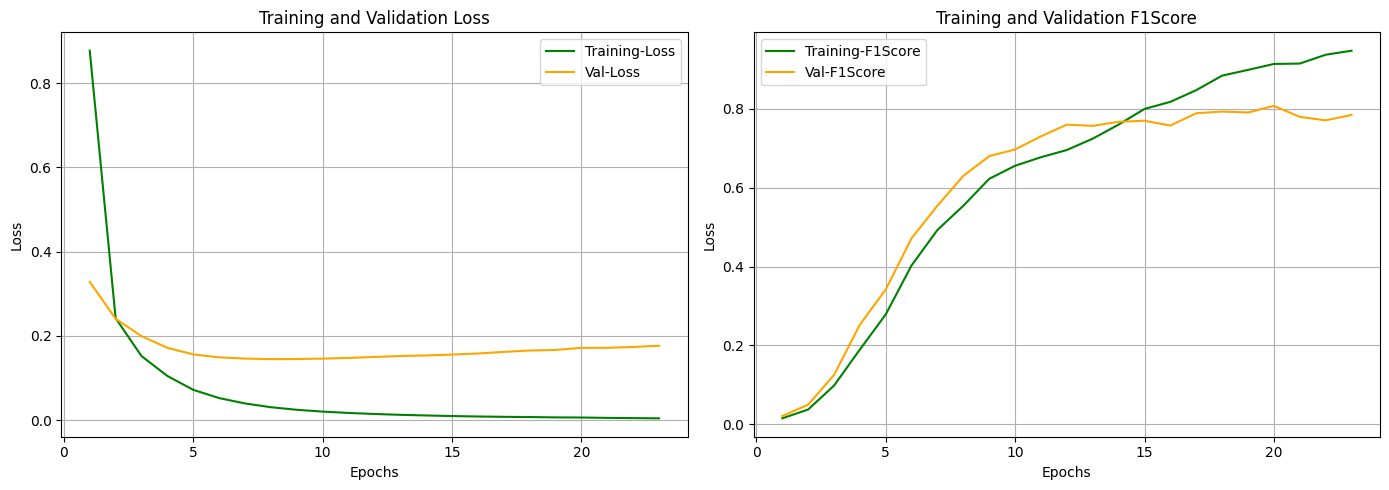

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9890 - loss: 0.1714
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.72


In [27]:
#TODO
embedding_dim = 100
vocab_size = num_words + 1
batch_size = 32
epochs = 30

model_baseline = Sequential()
model_baseline.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_baseline.add(LSTM(units=64, return_sequences=True))
model_baseline.add(Dense(128, activation='relu'))
model_baseline.add(Dense(num_unique_entities, activation='softmax'))
_, _ = run_model(model_baseline, epochs, batch_size)

## Mida d'Embeddings

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 1: F1-Score Macro Train= 0.0143, F1-Score Macro Val = 0.0204
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8710 - loss: 1.7294 - val_accuracy: 0.9285 - val_loss: 0.3342
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0312, F1-Score Macro Val = 0.0425
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9385 - loss: 0.2765 - val_accuracy: 0.9508 - val_loss: 0.2489
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 3: F1-Score Macro Train= 0.0823, F1-Score Macro Val = 0.1083
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9595 - loss: 0.1736 - val_accuracy: 0.9640 - val_loss: 0.2088
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.1413, F1-Score Macro Val = 0.1837
128/128 ━━

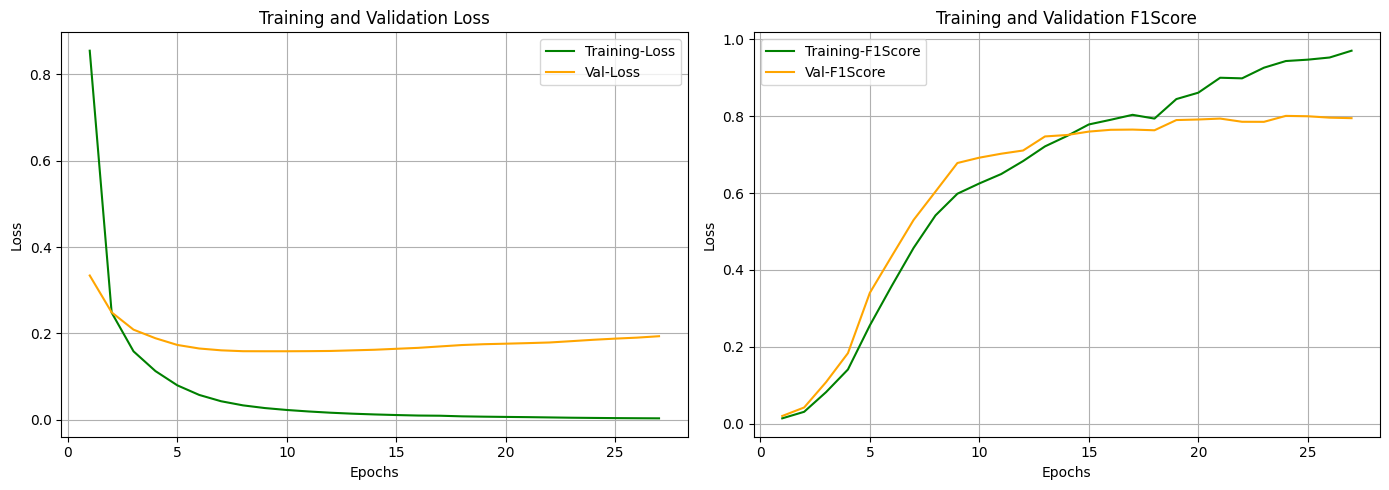

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9888 - loss: 0.1868
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.72


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0143, F1-Score Macro Val = 0.0204
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8710 - loss: 1.7294 - val_accuracy: 0.9285 - val_loss: 0.3342
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 2: F1-Score Macro Train= 0.0312, F1-Score Macro Val = 0.0425
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9385 - loss: 0.2765 - val_accuracy: 0.9508 - val_loss: 0.2489
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score Macro Train= 0.0823, F1-Score Macro Val = 0.1083
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9595 - loss: 0.1736 - val_accuracy: 0.9640 - val_loss: 0.2088
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.1413, F1-Score Macro Val = 0.1839
128/128 ━━

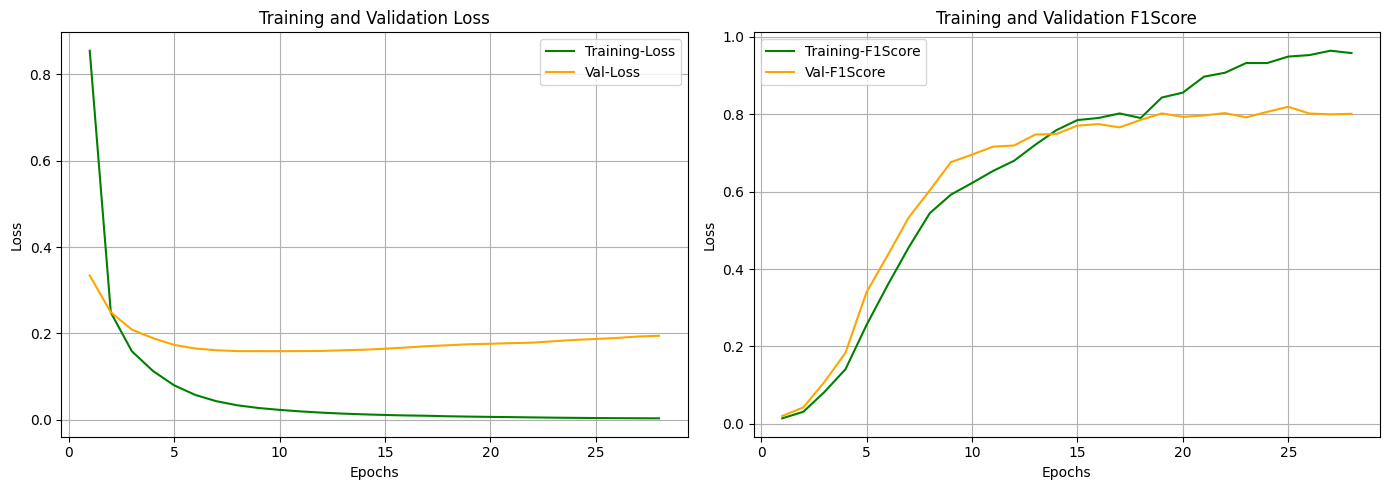

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9889 - loss: 0.1887
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.72


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 1: F1-Score Macro Train= 0.0143, F1-Score Macro Val = 0.0204
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8710 - loss: 1.7294 - val_accuracy: 0.9285 - val_loss: 0.3342
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 2: F1-Score Macro Train= 0.0312, F1-Score Macro Val = 0.0425
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9385 - loss: 0.2765 - val_accuracy: 0.9508 - val_loss: 0.2489
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.0823, F1-Score Macro Val = 0.1083
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9595 - loss: 0.1736 - val_accuracy: 0.9640 - val_loss: 0.2088
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.1412, F1-Score Macro Val = 0.1841
128/128 ━━

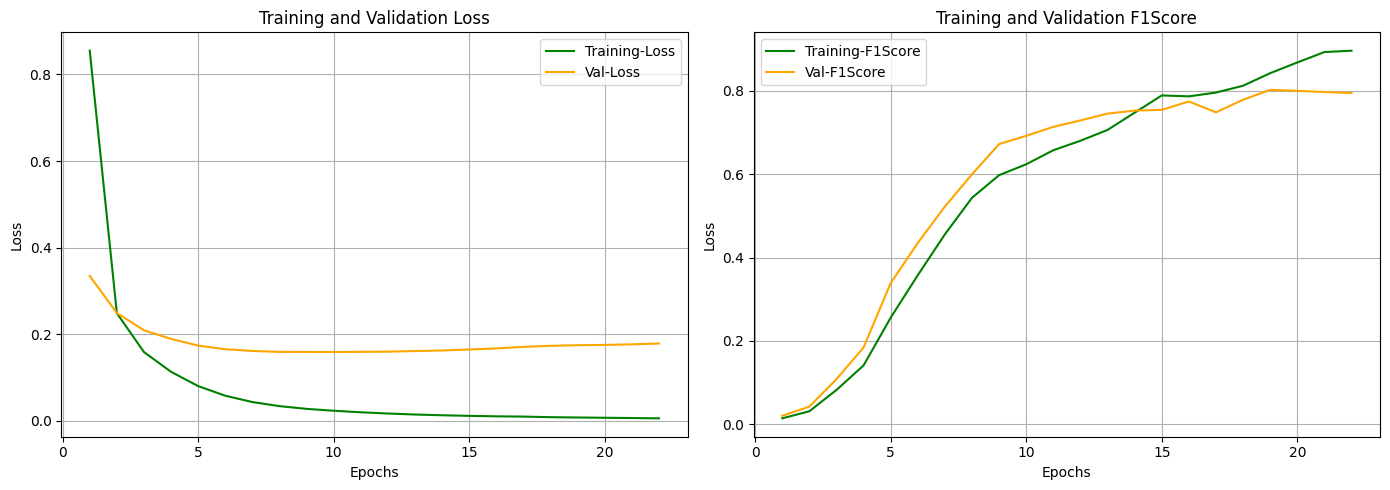

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9886 - loss: 0.1755
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.69


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0143, F1-Score Macro Val = 0.0204
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8710 - loss: 1.7294 - val_accuracy: 0.9286 - val_loss: 0.3342
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 2: F1-Score Macro Train= 0.0314, F1-Score Macro Val = 0.0421
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9385 - loss: 0.2765 - val_accuracy: 0.9508 - val_loss: 0.2488
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score Macro Train= 0.0826, F1-Score Macro Val = 0.1087
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9596 - loss: 0.1735 - val_accuracy: 0.9640 - val_loss: 0.2086
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.1415, F1-Score Macro Val = 0.1840
128/128 ━━

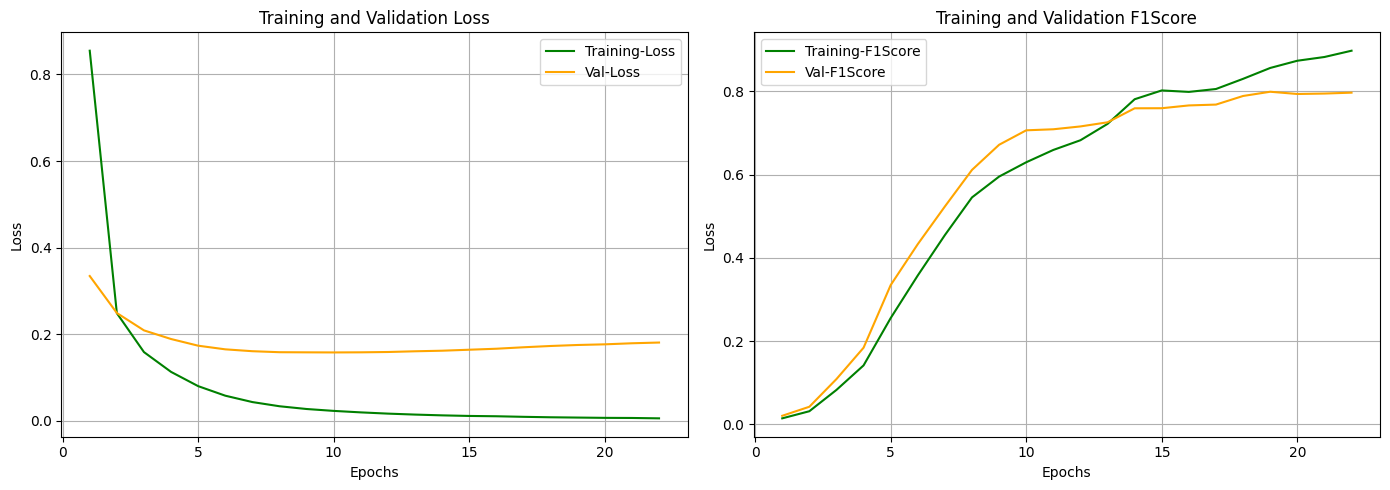

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9887 - loss: 0.1762
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.69


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 1: F1-Score Macro Train= 0.0143, F1-Score Macro Val = 0.0204
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8710 - loss: 1.7294 - val_accuracy: 0.9286 - val_loss: 0.3342
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0314, F1-Score Macro Val = 0.0421
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9385 - loss: 0.2765 - val_accuracy: 0.9508 - val_loss: 0.2488
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.0825, F1-Score Macro Val = 0.1088
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9596 - loss: 0.1735 - val_accuracy: 0.9640 - val_loss: 0.2086
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.1425, F1-Score Macro Val = 0.1834
128/128 ━━

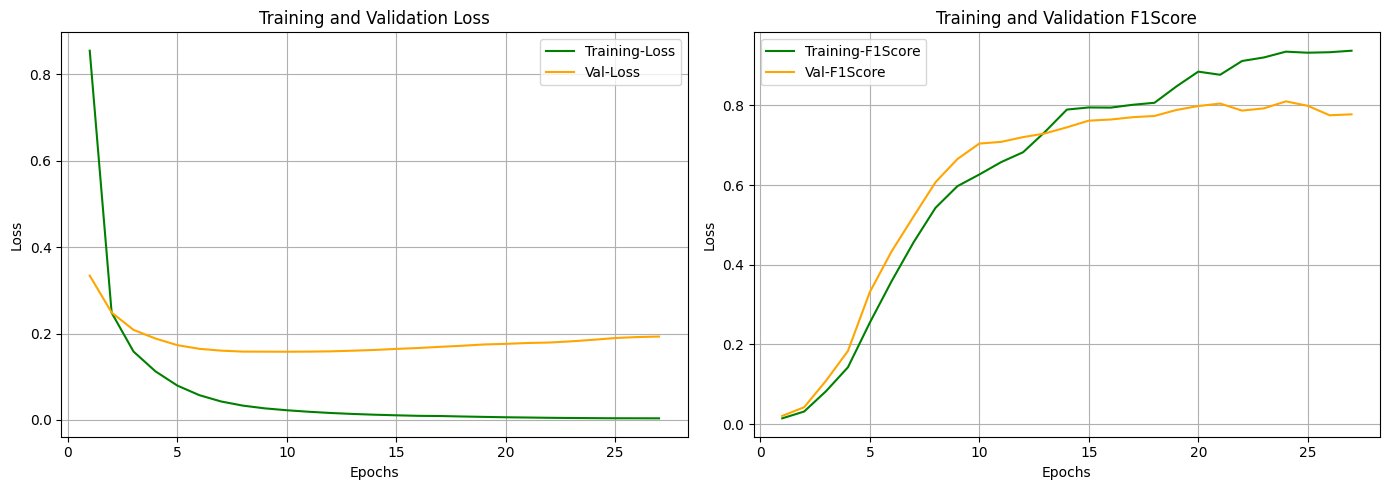

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9892 - loss: 0.1854
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.73


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 1: F1-Score Macro Train= 0.0143, F1-Score Macro Val = 0.0204
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8710 - loss: 1.7294 - val_accuracy: 0.9286 - val_loss: 0.3342
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0314, F1-Score Macro Val = 0.0421
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9385 - loss: 0.2765 - val_accuracy: 0.9508 - val_loss: 0.2488
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.0825, F1-Score Macro Val = 0.1088
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9596 - loss: 0.1735 - val_accuracy: 0.9640 - val_loss: 0.2086
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.1424, F1-Score Macro Val = 0.1834
128/128 ━━

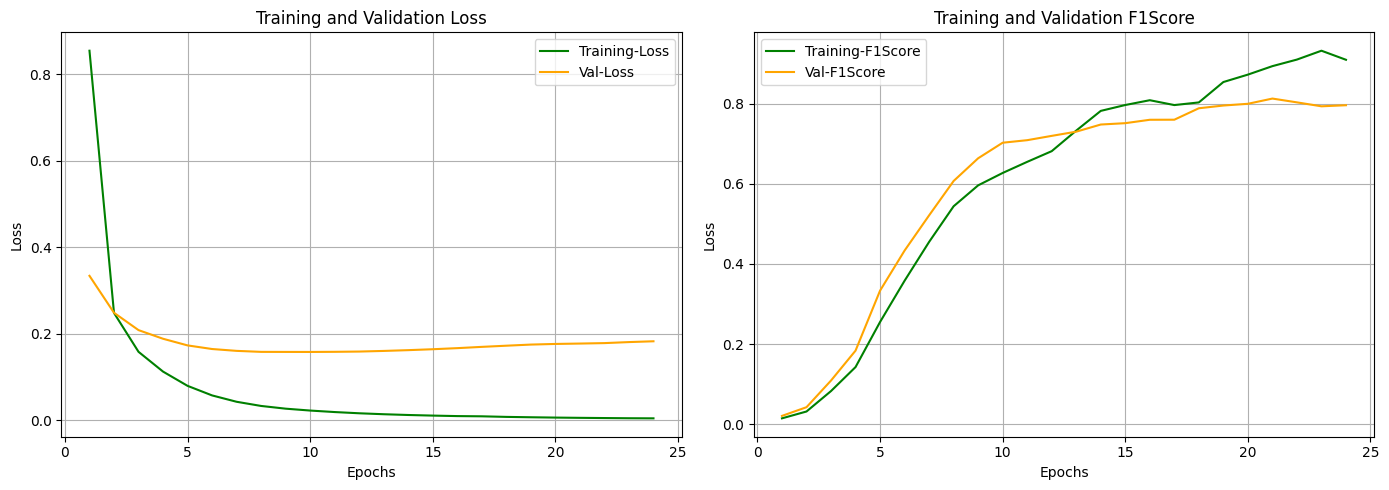

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9888 - loss: 0.1785
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.72


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0143, F1-Score Macro Val = 0.0204
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8710 - loss: 1.7294 - val_accuracy: 0.9286 - val_loss: 0.3342
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0313, F1-Score Macro Val = 0.0421
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9385 - loss: 0.2765 - val_accuracy: 0.9507 - val_loss: 0.2490
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score Macro Train= 0.0818, F1-Score Macro Val = 0.1080
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9597 - loss: 0.1738 - val_accuracy: 0.9639 - val_loss: 0.2093
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 4: F1-Score Macro Train= 0.1426, F1-Score Macro Val = 0.1840
128/128 ━━

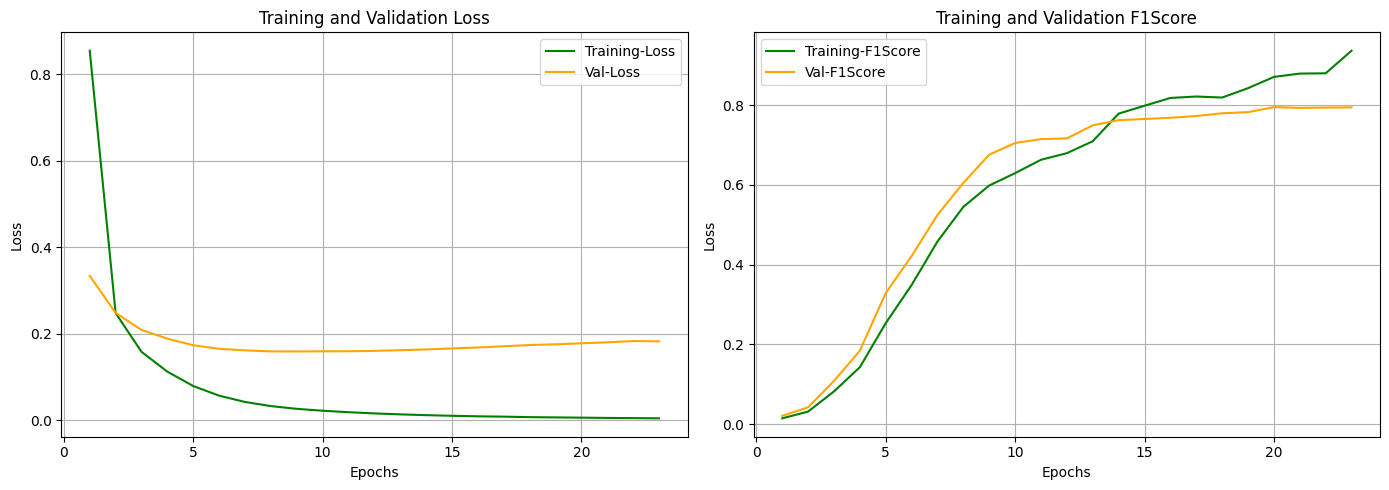

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9888 - loss: 0.1784
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.72


In [28]:
# Probar con diferentes dimensiones de embedding
embedding_dims = [50, 100, 150, 200, 250, 300, 350]
models_embs = [f'model_emb_{i}' for i in embedding_dims]
f1_score_train_emb = []
f1_score_val_emb = []

for i, emb_dim in enumerate(embedding_dims):
    models_embs[i] = Sequential()
    models_embs[i].add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
    models_embs[i].add(LSTM(units=64, return_sequences=True))
    models_embs[i].add(Dense(128, activation='relu'))
    models_embs[i].add(Dense(num_unique_entities, activation='softmax'))
    last_f1_train, best_f1 = run_model(models_embs[i], epochs, batch_size)
    f1_score_train_emb.append(last_f1_train)
    f1_score_val_emb.append(best_f1)

In [73]:
results_embs = {'experiment': embedding_dims, 'f1_score_train': f1_score_train_emb, 'f1_score_val': f1_score_val_emb}
pd.DataFrame(results_embs)

,experiment,f1_score_train,f1_score_val
0,50,0.943157,0.800566
1,100,0.949319,0.819496
2,150,0.842183,0.802067
3,200,0.856247,0.799088
4,250,0.934915,0.810141
5,300,0.894380,0.813360
6,350,0.871087,0.795224


In [30]:
best_emb = results_embs['embedding_dim'][np.argmax(results_embs['f1_score_val'])]

## Xarxes convolucionals

In [31]:
conv_tests = ['basic']
f1_score_train_conv = []
f1_score_val_conv = []

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0468, F1-Score Macro Val = 0.0617
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8825 - loss: 1.3728 - val_accuracy: 0.9539 - val_loss: 0.2780
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 2: F1-Score Macro Train= 0.1734, F1-Score Macro Val = 0.2411
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9652 - loss: 0.1513 - val_accuracy: 0.9776 - val_loss: 0.2160
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.3609, F1-Score Macro Val = 0.4072
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9835 - loss: 0.0684 - val_accuracy: 0.9824 - val_loss: 0.2000
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 4: F1-Score Macro Train= 0.4354, F1-Score Macro Val = 0.5254
128/128 ━

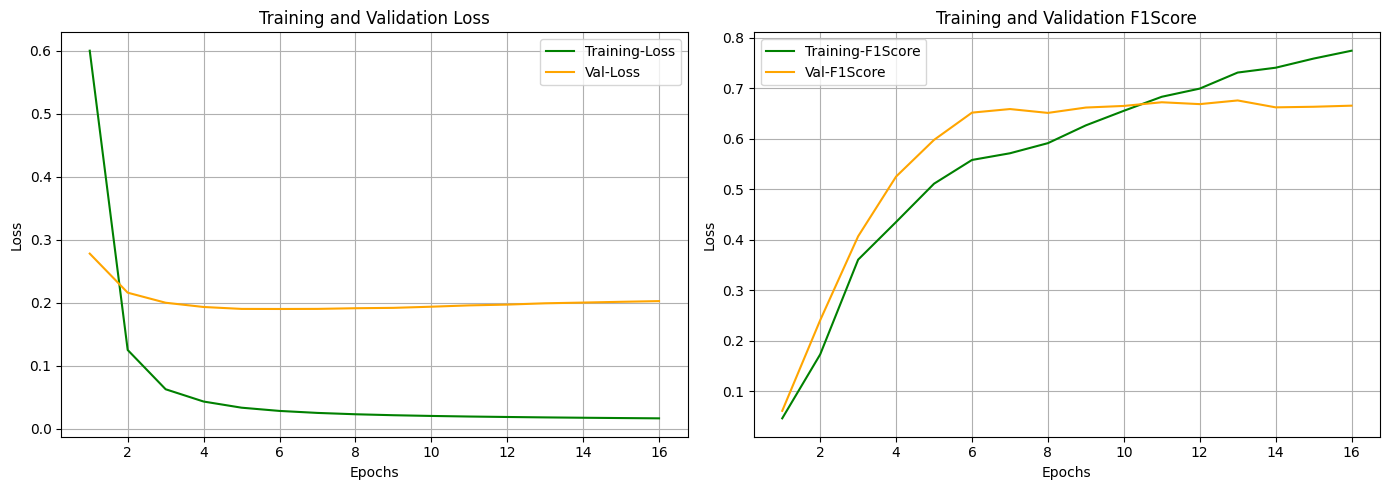

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9855 - loss: 0.1938
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.62


In [32]:
vocab_size = num_words + 1
batch_size = 32
epochs = 30

model_conv_1 = Sequential()
model_conv_1.add(Embedding(input_dim=vocab_size, output_dim=best_emb, input_length=max_sequence_length)) #layer 1
# Capa Conv1D para extracción de características
model_conv_1.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model_conv_1.add(Dense(128, activation='relu'))
model_conv_1.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_conv_1, epochs, batch_size)
f1_score_train_conv.append(last_f1_train)
f1_score_val_conv.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Epoch 1: F1-Score Macro Train= 0.0594, F1-Score Macro Val = 0.0807
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8867 - loss: 1.2732 - val_accuracy: 0.9570 - val_loss: 0.2824
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 2: F1-Score Macro Train= 0.1914, F1-Score Macro Val = 0.2536
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9692 - loss: 0.1370 - val_accuracy: 0.9783 - val_loss: 0.2212
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 3: F1-Score Macro Train= 0.3808, F1-Score Macro Val = 0.4624
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9847 - loss: 0.0619 - val_accuracy: 0.9832 - val_loss: 0.2060
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 4: F1-Score Macro Train= 0.4838, F1-Score Macro Val = 0.5658
128/128 ━

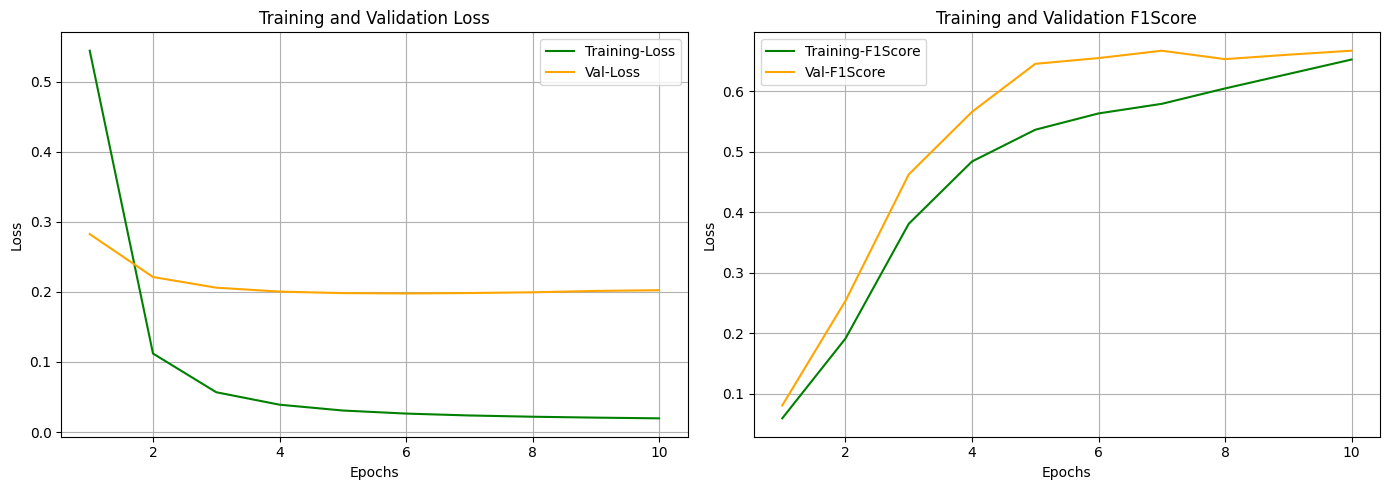

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9850 - loss: 0.1935
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.59


In [33]:
conv_tests.append('more_filters_512')
model_conv_2 = Sequential()
model_conv_2.add(Embedding(input_dim=vocab_size, output_dim=best_emb, input_length=max_sequence_length)) #layer 1
# Capa Conv1D para extracción de características
model_conv_2.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model_conv_2.add(Dense(128, activation='relu'))
model_conv_2.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_conv_2, epochs, batch_size)
f1_score_train_conv.append(last_f1_train)
f1_score_val_conv.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0467, F1-Score Macro Val = 0.0612
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8799 - loss: 1.5206 - val_accuracy: 0.9543 - val_loss: 0.2744
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 2: F1-Score Macro Train= 0.1599, F1-Score Macro Val = 0.2129
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9649 - loss: 0.1570 - val_accuracy: 0.9765 - val_loss: 0.2151
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.2932, F1-Score Macro Val = 0.3566
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9827 - loss: 0.0736 - val_accuracy: 0.9810 - val_loss: 0.1999
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.4277, F1-Score Macro Val = 0.5142
128/128 ━━

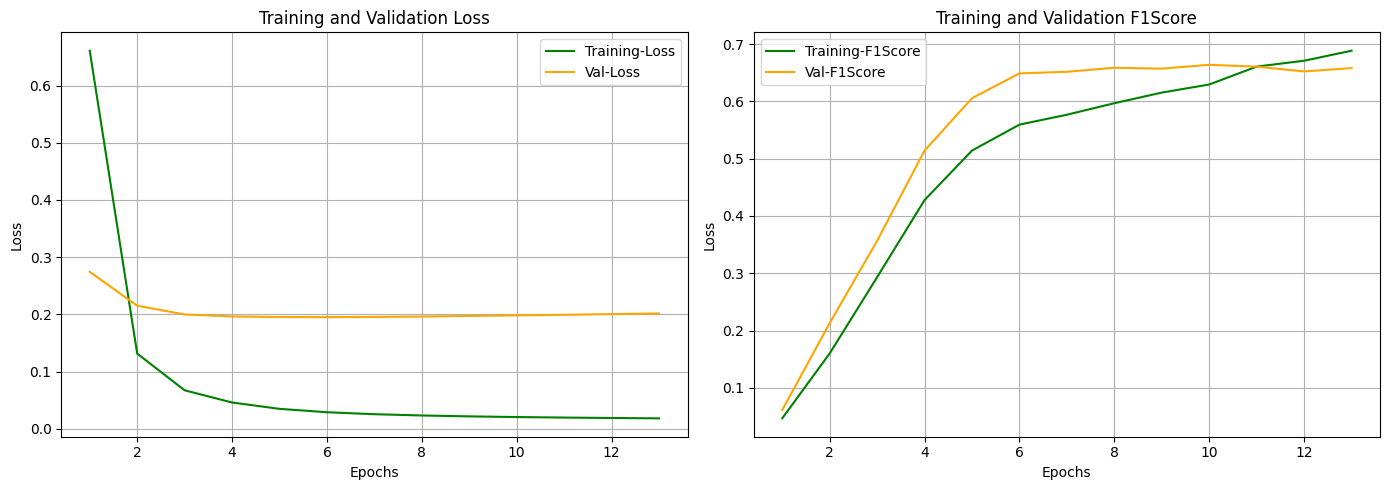

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9850 - loss: 0.1927
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.60


In [34]:
conv_tests.append('less_filters_128')
model_conv_3 = Sequential()
model_conv_3.add(Embedding(input_dim=vocab_size, output_dim=best_emb, input_length=max_sequence_length)) #layer 1
# Capa Conv1D para extracción de características
model_conv_3.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model_conv_3.add(Dense(128, activation='relu'))
model_conv_3.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_conv_3, epochs, batch_size)
f1_score_train_conv.append(last_f1_train)
f1_score_val_conv.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 1: F1-Score Macro Train= 0.0786, F1-Score Macro Val = 0.1073
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8874 - loss: 1.1146 - val_accuracy: 0.9618 - val_loss: 0.2394
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 2: F1-Score Macro Train= 0.2375, F1-Score Macro Val = 0.3044
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9724 - loss: 0.1218 - val_accuracy: 0.9802 - val_loss: 0.1907
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.4081, F1-Score Macro Val = 0.4755
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9868 - loss: 0.0575 - val_accuracy: 0.9845 - val_loss: 0.1863
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Epoch 4: F1-Score Macro Train= 0.5282, F1-Score Macro Val = 0.5820
128/128 

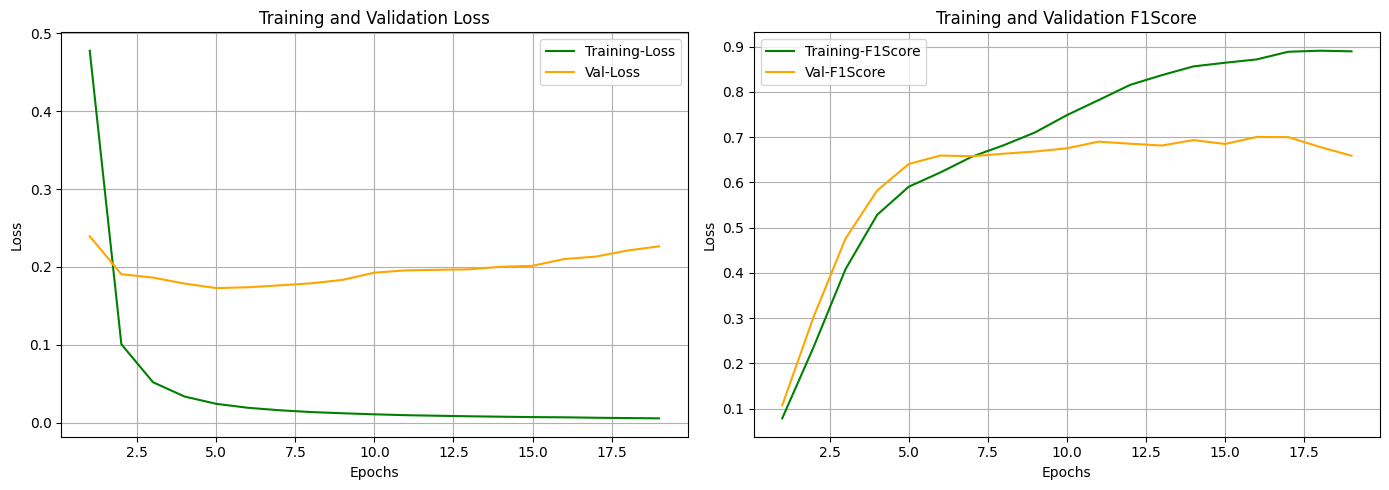

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9878 - loss: 0.1930
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.62


In [35]:
conv_tests.append('more_layers_1')
model_conv_4 = Sequential()
model_conv_4.add(Embedding(input_dim=vocab_size, output_dim=best_emb, input_length=max_sequence_length)) #layer 1
model_conv_4.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model_conv_4.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model_conv_4.add(Dense(128, activation='relu'))
model_conv_4.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_conv_4, epochs, batch_size)
f1_score_train_conv.append(last_f1_train)
f1_score_val_conv.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Epoch 1: F1-Score Macro Train= 0.0724, F1-Score Macro Val = 0.0991
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.8831 - loss: 1.0025 - val_accuracy: 0.9610 - val_loss: 0.2090
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 2: F1-Score Macro Train= 0.2429, F1-Score Macro Val = 0.2883
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9716 - loss: 0.1239 - val_accuracy: 0.9787 - val_loss: 0.1623
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.4299, F1-Score Macro Val = 0.4942
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9855 - loss: 0.0589 - val_accuracy: 0.9850 - val_loss: 0.1513
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.5532, F1-Score Macro Val = 0.6001
128/128 

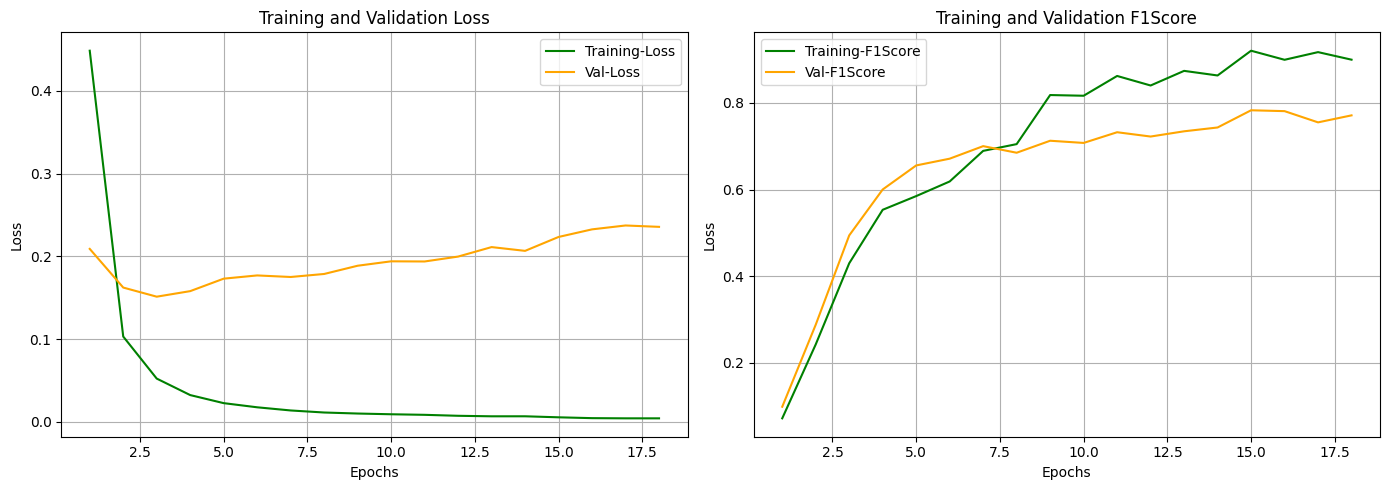

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9876 - loss: 0.2095
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.65


In [36]:
conv_tests.append('more_layers_2')
model_conv_5 = Sequential()
model_conv_5.add(Embedding(input_dim=vocab_size, output_dim=best_emb, input_length=max_sequence_length)) #layer 1
model_conv_5.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model_conv_5.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model_conv_5.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
model_conv_5.add(Dense(128, activation='relu'))
model_conv_5.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_conv_5, epochs, batch_size)
f1_score_train_conv.append(last_f1_train)
f1_score_val_conv.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Epoch 1: F1-Score Macro Train= 0.0821, F1-Score Macro Val = 0.1143
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.8836 - loss: 0.9118 - val_accuracy: 0.9623 - val_loss: 0.2047
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.2558, F1-Score Macro Val = 0.3195
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9711 - loss: 0.1258 - val_accuracy: 0.9792 - val_loss: 0.1631
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score Macro Train= 0.4463, F1-Score Macro Val = 0.4655
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9852 - loss: 0.0596 - val_accuracy: 0.9841 - val_loss: 0.1627
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.5432, F1-Score Macro Val = 0.5794
128/128

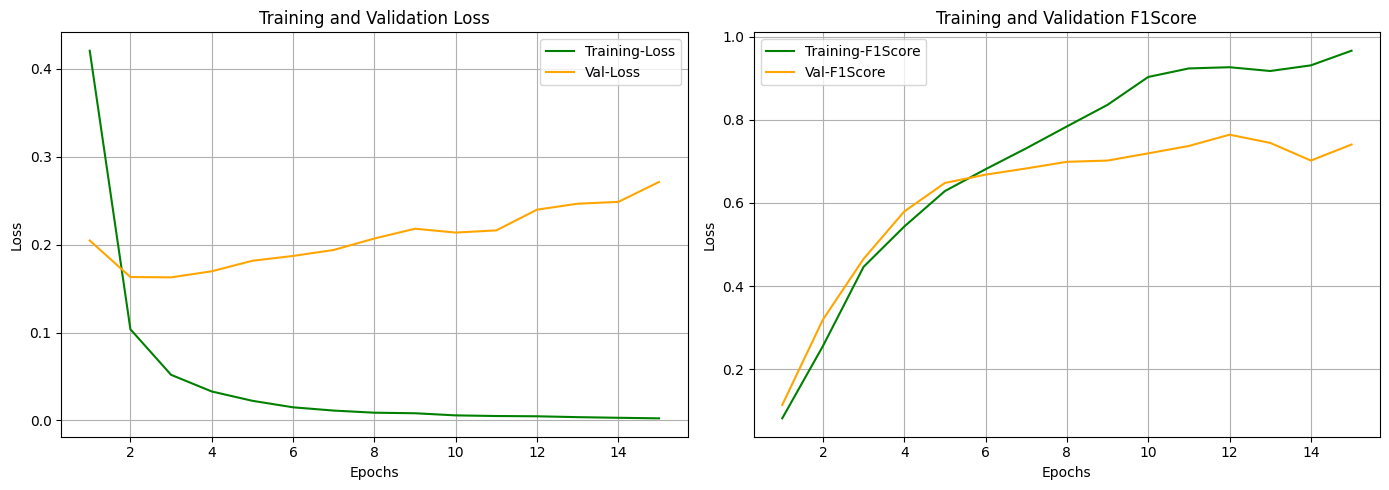

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9886 - loss: 0.2196
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.65


In [58]:
conv_tests.append('kernel_size_5')
model_conv_6 = Sequential()
model_conv_6.add(Embedding(input_dim=vocab_size, output_dim=best_emb, input_length=max_sequence_length)) #layer 1
model_conv_6.add(Conv1D(filters=512, kernel_size=5, activation='relu', padding='same'))
model_conv_6.add(Conv1D(filters=512, kernel_size=5, activation='relu', padding='same'))
model_conv_6.add(Conv1D(filters=512, kernel_size=5, activation='relu', padding='same'))
model_conv_6.add(Dense(128, activation='relu'))
model_conv_6.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_conv_6, epochs, batch_size)
f1_score_train_conv.append(last_f1_train)
f1_score_val_conv.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Epoch 1: F1-Score Macro Train= 0.0747, F1-Score Macro Val = 0.0977
128/128 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.8814 - loss: 0.9104 - val_accuracy: 0.9598 - val_loss: 0.2040
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.2434, F1-Score Macro Val = 0.2936
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9692 - loss: 0.1345 - val_accuracy: 0.9777 - val_loss: 0.1562
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score Macro Train= 0.4555, F1-Score Macro Val = 0.4567
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9844 - loss: 0.0637 - val_accuracy: 0.9819 - val_loss: 0.1567
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.5980, F1-Score Macro Val = 0.5992
128/128 

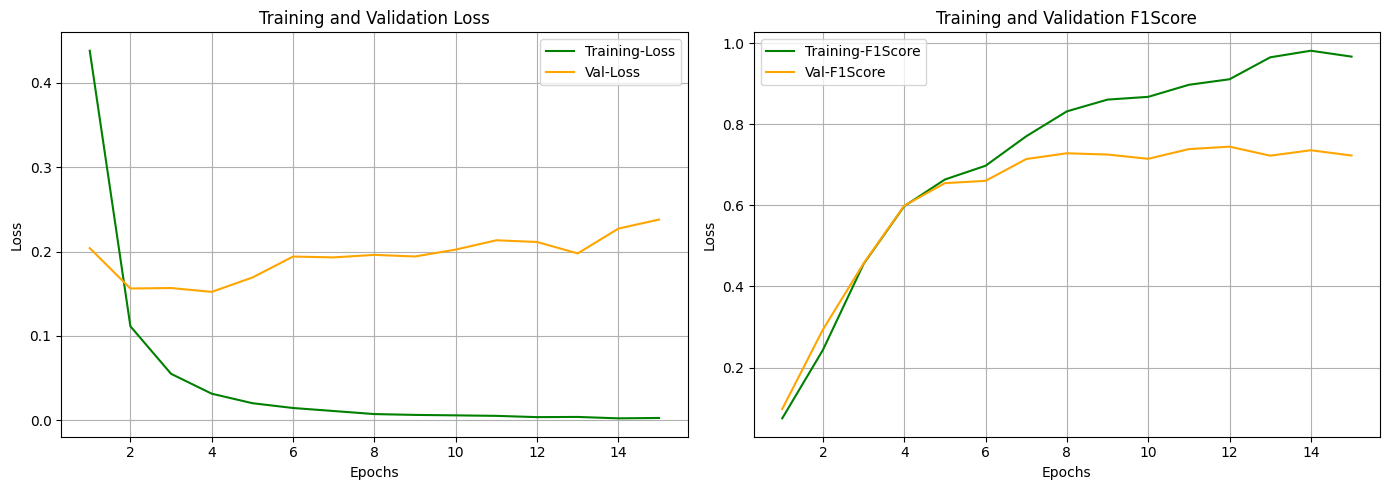

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9877 - loss: 0.2006
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.69


In [59]:
conv_tests.append('kernel_size_7')
model_conv_7 = Sequential()
model_conv_7.add(Embedding(input_dim=vocab_size, output_dim=best_emb, input_length=max_sequence_length)) #layer 1
model_conv_7.add(Conv1D(filters=512, kernel_size=7, activation='relu', padding='same'))
model_conv_7.add(Conv1D(filters=512, kernel_size=7, activation='relu', padding='same'))
model_conv_7.add(Conv1D(filters=512, kernel_size=7, activation='relu', padding='same'))
model_conv_7.add(Dense(128, activation='relu'))
model_conv_7.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_conv_7, epochs, batch_size)
f1_score_train_conv.append(last_f1_train)
f1_score_val_conv.append(best_f1)

In [60]:
results_conv = {'experiment': conv_tests, 'f1_score_train': f1_score_train_conv, 'f1_score_val': f1_score_val_conv}
pd.DataFrame(results_conv)

,experiment,f1_score_train,f1_score_val
0,basic,0.731246,0.676018
1,more_filters_512,0.579052,0.666804
2,less_filters_128,0.629499,0.663865
3,more_layers_1,0.871662,0.700237
4,more_layers_2,0.919996,0.782655
5,kernel_size_5,0.926330,0.764104
6,kernel_size_7,0.911162,0.744866


## Xarxes recurrents

In [38]:
rnn_tests = ['basic']
f1_score_train_rnn = [f1_score_train_emb[np.argmax(f1_score_val_emb)]]
f1_score_val_rnn = [f1_score_val_emb[np.argmax(f1_score_val_emb)]]

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0153, F1-Score Macro Val = 0.0211
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8719 - loss: 1.5791 - val_accuracy: 0.9315 - val_loss: 0.3287
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0480, F1-Score Macro Val = 0.0645
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9407 - loss: 0.2618 - val_accuracy: 0.9536 - val_loss: 0.2480
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.1032, F1-Score Macro Val = 0.1400
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9626 - loss: 0.1582 - val_accuracy: 0.9663 - val_loss: 0.2125
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.2021, F1-Score Macro Val = 0.2816
128/128 ━━

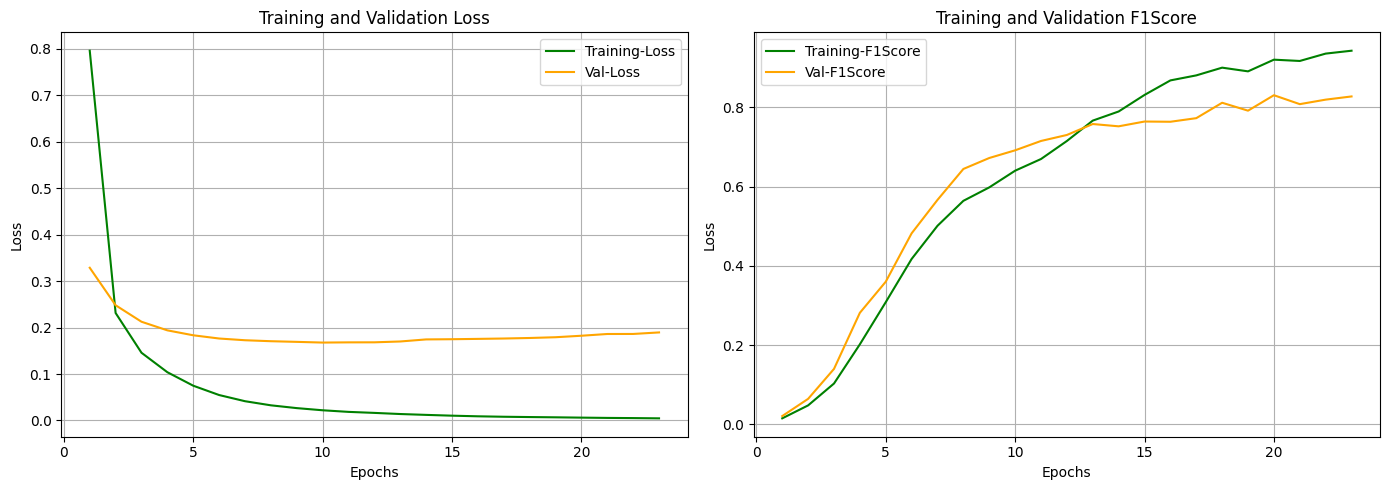

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9887 - loss: 0.1839
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.72


In [39]:
rnn_tests.append("lstm_more_units_128")
model_rnn_2 = Sequential()
model_rnn_2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_rnn_2.add(LSTM(units=128, return_sequences=True))
model_rnn_2.add(Dense(128, activation='relu'))
model_rnn_2.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_rnn_2, epochs, batch_size)
f1_score_train_rnn.append(last_f1_train)
f1_score_val_rnn.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 1: F1-Score Macro Train= 0.0154, F1-Score Macro Val = 0.0212
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8725 - loss: 1.4487 - val_accuracy: 0.9314 - val_loss: 0.3343
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 2: F1-Score Macro Train= 0.0552, F1-Score Macro Val = 0.0754
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9416 - loss: 0.2509 - val_accuracy: 0.9559 - val_loss: 0.2561
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score Macro Train= 0.1284, F1-Score Macro Val = 0.1703
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9627 - loss: 0.1504 - val_accuracy: 0.9661 - val_loss: 0.2385
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.1934, F1-Score Macro Val = 0.2473
128/128 ━━

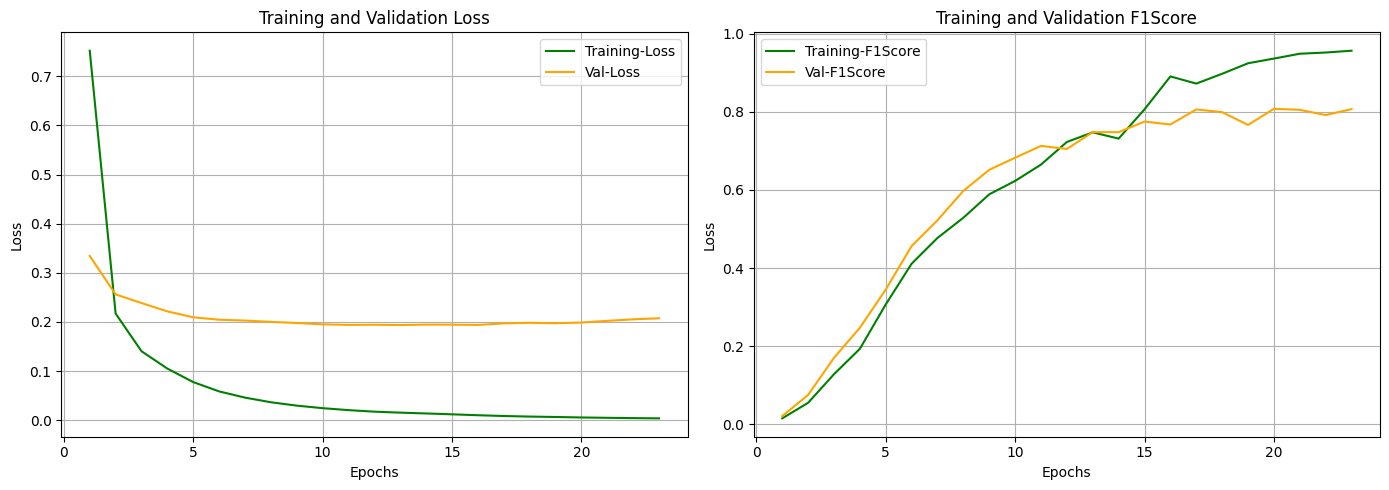

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9874 - loss: 0.2021
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.68


In [40]:
rnn_tests.append("lstm_more_units_256")
model_rnn_3 = Sequential()
model_rnn_3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_rnn_3.add(LSTM(units=256, return_sequences=True))
model_rnn_3.add(Dense(128, activation='relu'))
model_rnn_3.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_rnn_3, epochs, batch_size)
f1_score_train_rnn.append(last_f1_train)
f1_score_val_rnn.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 1: F1-Score Macro Train= 0.0209, F1-Score Macro Val = 0.0307
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8717 - loss: 1.4486 - val_accuracy: 0.9410 - val_loss: 0.3039
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 2: F1-Score Macro Train= 0.1109, F1-Score Macro Val = 0.1503
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9529 - loss: 0.2110 - val_accuracy: 0.9680 - val_loss: 0.2167
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.2184, F1-Score Macro Val = 0.2888
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9761 - loss: 0.1102 - val_accuracy: 0.9794 - val_loss: 0.1826
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.3658, F1-Score Macro Val = 0.4266
128/128 ━━

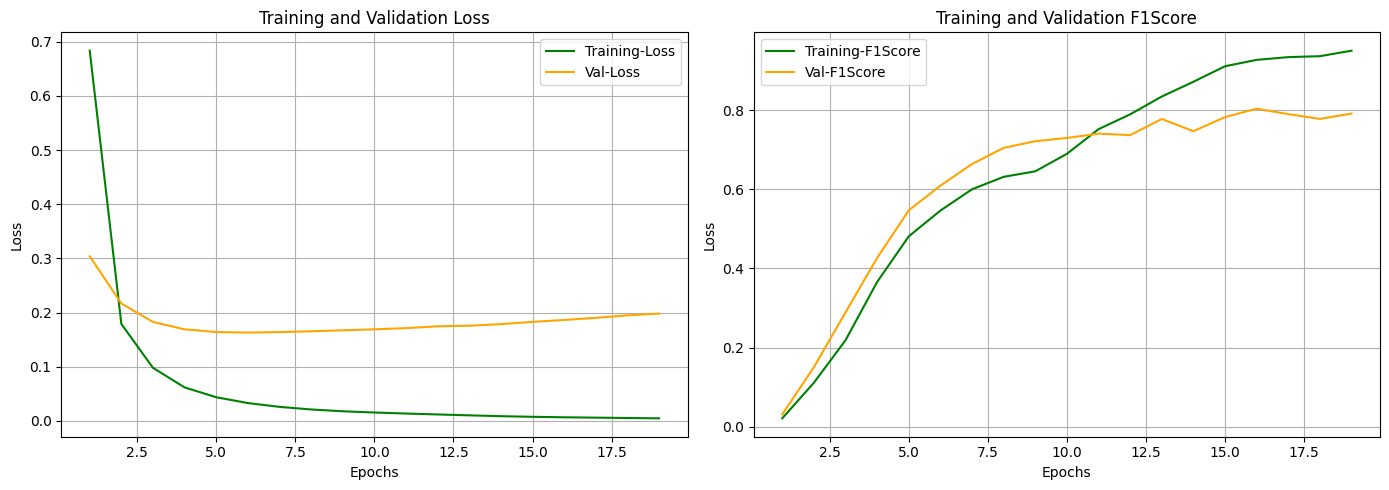

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9900 - loss: 0.1840
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.74


In [41]:
rnn_tests.append("gru_more_units_128")
model_rnn_4 = Sequential()
model_rnn_4.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_rnn_4.add(GRU(units=128, return_sequences=True))
model_rnn_4.add(Dense(128, activation='relu'))
model_rnn_4.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_rnn_4, epochs, batch_size)
f1_score_train_rnn.append(last_f1_train)
f1_score_val_rnn.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 1: F1-Score Macro Train= 0.0234, F1-Score Macro Val = 0.0332
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8743 - loss: 1.3298 - val_accuracy: 0.9462 - val_loss: 0.3039
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 2: F1-Score Macro Train= 0.1089, F1-Score Macro Val = 0.1420
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9551 - loss: 0.1937 - val_accuracy: 0.9659 - val_loss: 0.2503
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.2020, F1-Score Macro Val = 0.2651
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9734 - loss: 0.1152 - val_accuracy: 0.9778 - val_loss: 0.2223
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.3535, F1-Score Macro Val = 0.4115
128/128 ━━

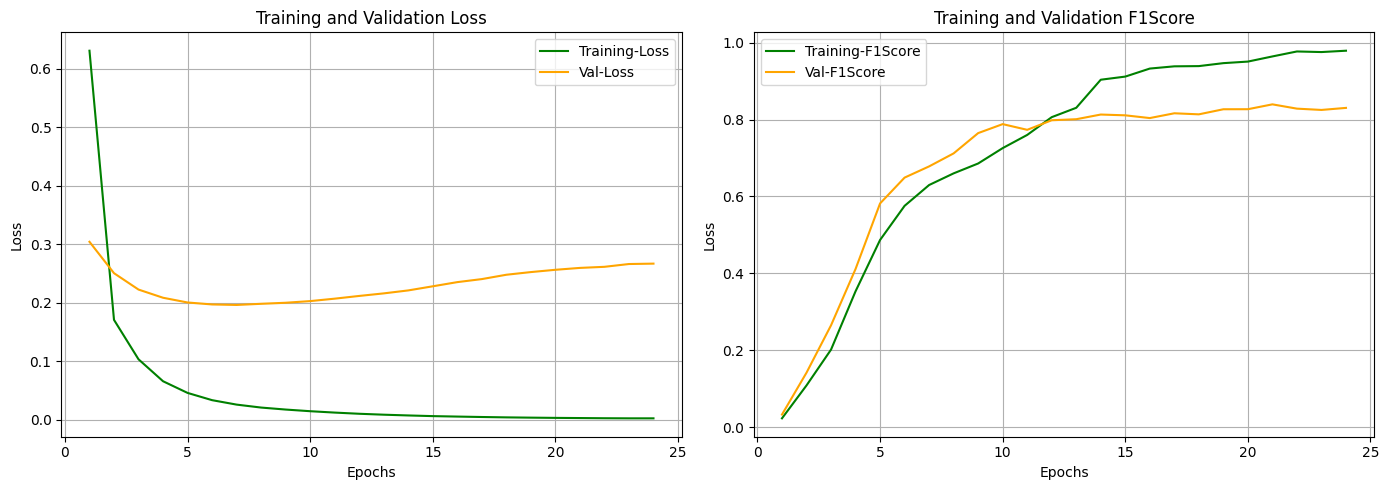

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9896 - loss: 0.2628
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.74


In [42]:
rnn_tests.append("gru_more_units_256")
model_rnn_5 = Sequential()
model_rnn_5.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_rnn_5.add(GRU(units=256, return_sequences=True))
model_rnn_5.add(Dense(128, activation='relu'))
model_rnn_5.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_rnn_5, epochs, batch_size)
f1_score_train_rnn.append(last_f1_train)
f1_score_val_rnn.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0180, F1-Score Macro Val = 0.0254
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8725 - loss: 1.1147 - val_accuracy: 0.9350 - val_loss: 0.3298
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0852, F1-Score Macro Val = 0.1184
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9465 - loss: 0.2491 - val_accuracy: 0.9621 - val_loss: 0.2134
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 3: F1-Score Macro Train= 0.1935, F1-Score Macro Val = 0.2542
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9694 - loss: 0.1320 - val_accuracy: 0.9751 - val_loss: 0.1826
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 4: F1-Score Macro Train= 0.3152, F1-Score Macro Val = 0.3909
128/128 ━━

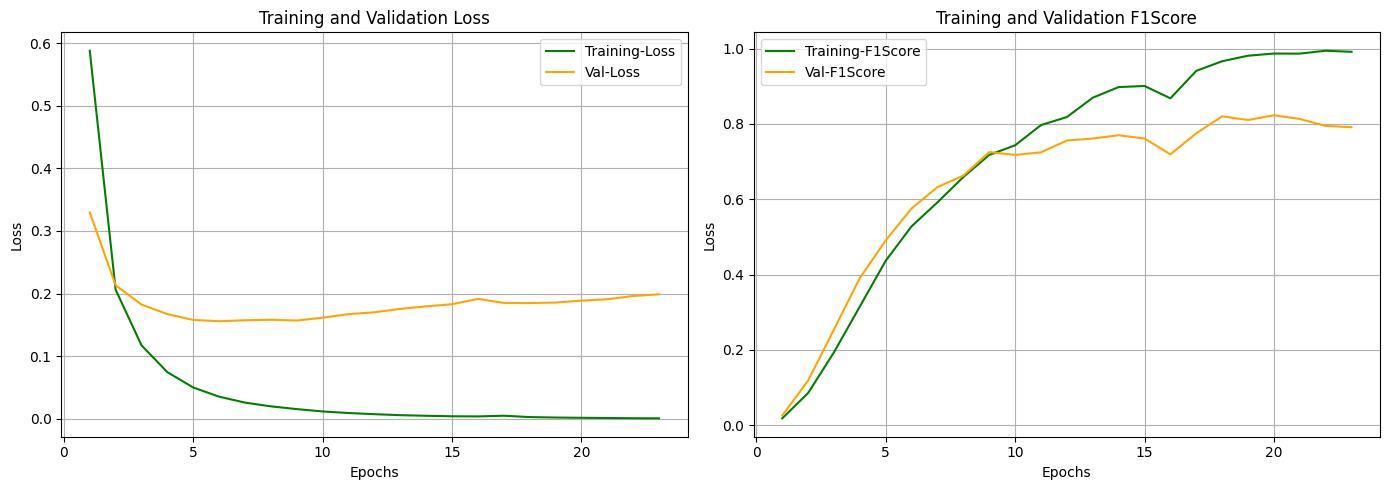

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9892 - loss: 0.1745
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.73


In [43]:
rnn_tests.append("lstm_bidirec")
model_rnn_6 = Sequential()
model_rnn_6.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_rnn_6.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model_rnn_6.add(Dense(128, activation='relu'))
model_rnn_6.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_rnn_6, epochs, batch_size)
f1_score_train_rnn.append(last_f1_train)
f1_score_val_rnn.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0299, F1-Score Macro Val = 0.0413
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8745 - loss: 1.2088 - val_accuracy: 0.9489 - val_loss: 0.2702
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.1488, F1-Score Macro Val = 0.2069
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9582 - loss: 0.1848 - val_accuracy: 0.9715 - val_loss: 0.1992
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score Macro Train= 0.2910, F1-Score Macro Val = 0.3423
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9783 - loss: 0.0967 - val_accuracy: 0.9809 - val_loss: 0.1652
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 4: F1-Score Macro Train= 0.4391, F1-Score Macro Val = 0.4900
128/128 ━━

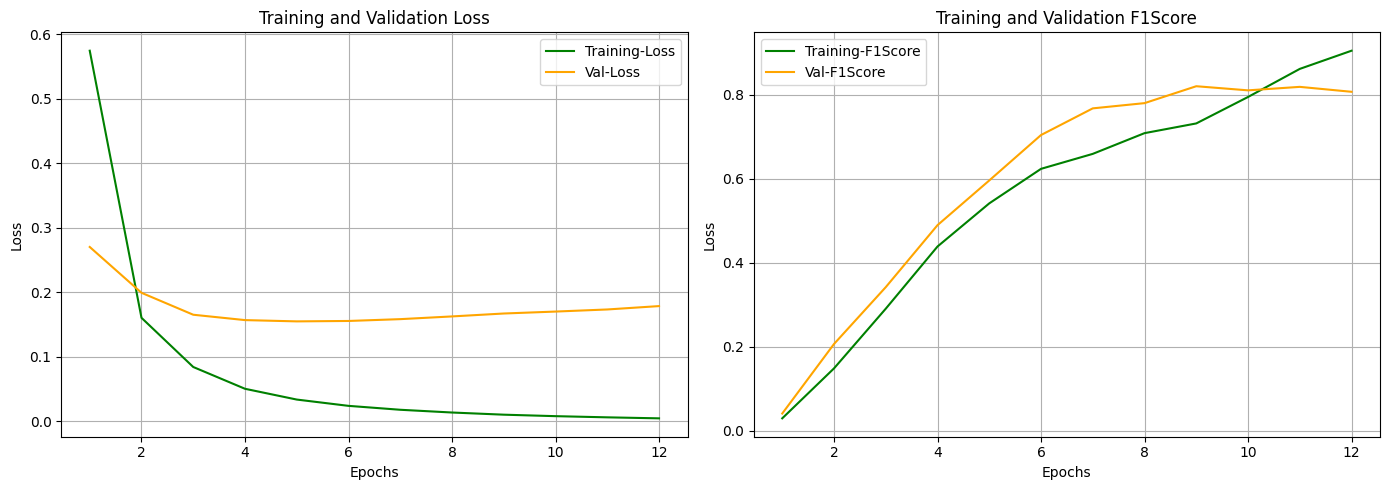

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9896 - loss: 0.1750
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.72


In [44]:
rnn_tests.append("gru_bidirect")
model_rnn_5 = Sequential()
model_rnn_5.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_rnn_5.add(Bidirectional(GRU(units=256, return_sequences=True)))
model_rnn_5.add(Dense(128, activation='relu'))
model_rnn_5.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_rnn_5, epochs, batch_size)
f1_score_train_rnn.append(last_f1_train)
f1_score_val_rnn.append(best_f1)

In [45]:
results_rnn = {'experiment': rnn_tests, 'f1_score_train': f1_score_train_rnn, 'f1_score_val': f1_score_val_rnn}
pd.DataFrame(results_rnn)

,experiment,f1_score_train,f1_score_val
0,basic,0.949319,0.819496
1,lstm_more_units_128,0.920266,0.830580
2,lstm_more_units_256,0.936398,0.807753
3,gru_more_units_128,0.927529,0.804012
4,gru_more_units_256,0.963936,0.839430
5,lstm_bidirec,0.987085,0.823044
6,gru_bidirect,0.732276,0.820886


## Transformers

In [46]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings


In [47]:
transf_tests = ['basic']
f1_score_train_transf = []
f1_score_val_transf = []

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Epoch 1: F1-Score Macro Train= 0.2919, F1-Score Macro Val = 0.3746
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - accuracy: 0.8917 - loss: 0.6775 - val_accuracy: 0.9669 - val_loss: 0.1448
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 2: F1-Score Macro Train= 0.4011, F1-Score Macro Val = 0.4683
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9730 - loss: 0.0874 - val_accuracy: 0.9706 - val_loss: 0.1306
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.4907, F1-Score Macro Val = 0.5505
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9769 - loss: 0.0661 - val_accuracy: 0.9746 - val_loss: 0.1224
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.5454, F1-Score Macro Val = 0.5822
128/12

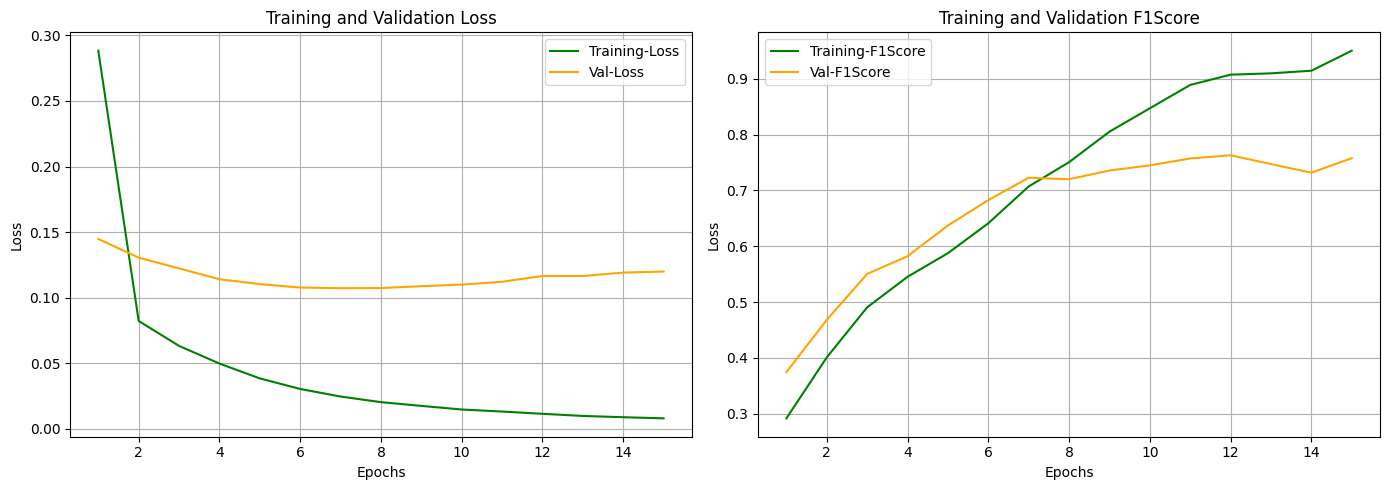

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9857 - loss: 0.1139
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.66


In [48]:
# Parámetros del modelo
batch_size = 32
epochs = 30
num_heads = 4
ff_dim = 128
vocab_size = num_words + 1

# Construir el modelo
model_transf_1 = Sequential()
model_transf_1.add(TokenAndPositionEmbedding(train_pad_sequences.shape[1], vocab_size, best_emb))
model_transf_1.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_1.add(Dense(128, activation='relu'))
model_transf_1.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_transf_1, epochs, batch_size)
f1_score_train_transf.append(last_f1_train)
f1_score_val_transf.append(best_f1)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Epoch 1: F1-Score Macro Train= 0.2875, F1-Score Macro Val = 0.3754
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.8914 - loss: 0.6756 - val_accuracy: 0.9672 - val_loss: 0.1447
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 2: F1-Score Macro Train= 0.4042, F1-Score Macro Val = 0.4666
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9730 - loss: 0.0884 - val_accuracy: 0.9699 - val_loss: 0.1306
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.4872, F1-Score Macro Val = 0.5490
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9766 - loss: 0.0668 - val_accuracy: 0.9745 - val_loss: 0.1227
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.5502, F1-Score Macro Val = 0.5778
128/128 

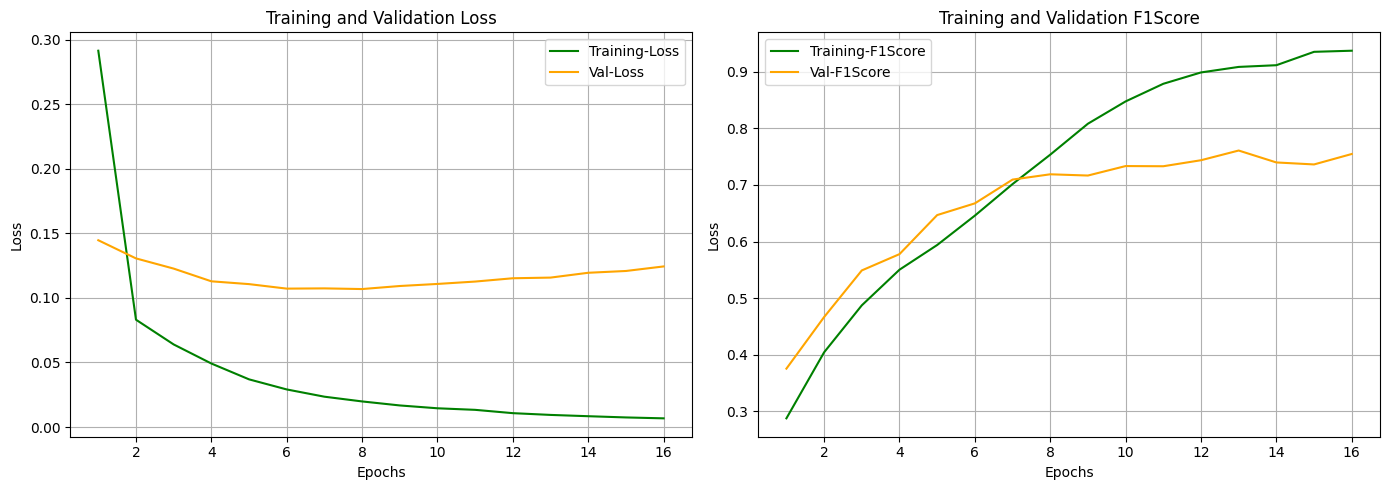

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9859 - loss: 0.1178
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.66


In [49]:
transf_tests.append("more_heads_6")
num_heads = 6
model_transf_2 = Sequential()
model_transf_2.add(TokenAndPositionEmbedding(train_pad_sequences.shape[1], vocab_size, best_emb))
model_transf_2.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_2.add(Dense(128, activation='relu'))
model_transf_2.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_transf_2, epochs, batch_size)
f1_score_train_transf.append(last_f1_train)
f1_score_val_transf.append(best_f1)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Epoch 1: F1-Score Macro Train= 0.2866, F1-Score Macro Val = 0.3732
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.8912 - loss: 0.6770 - val_accuracy: 0.9668 - val_loss: 0.1458
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.4036, F1-Score Macro Val = 0.4708
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9728 - loss: 0.0886 - val_accuracy: 0.9702 - val_loss: 0.1307
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.4918, F1-Score Macro Val = 0.5479
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9771 - loss: 0.0662 - val_accuracy: 0.9751 - val_loss: 0.1223
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.5509, F1-Score Macro Val = 0.5813
128/128 

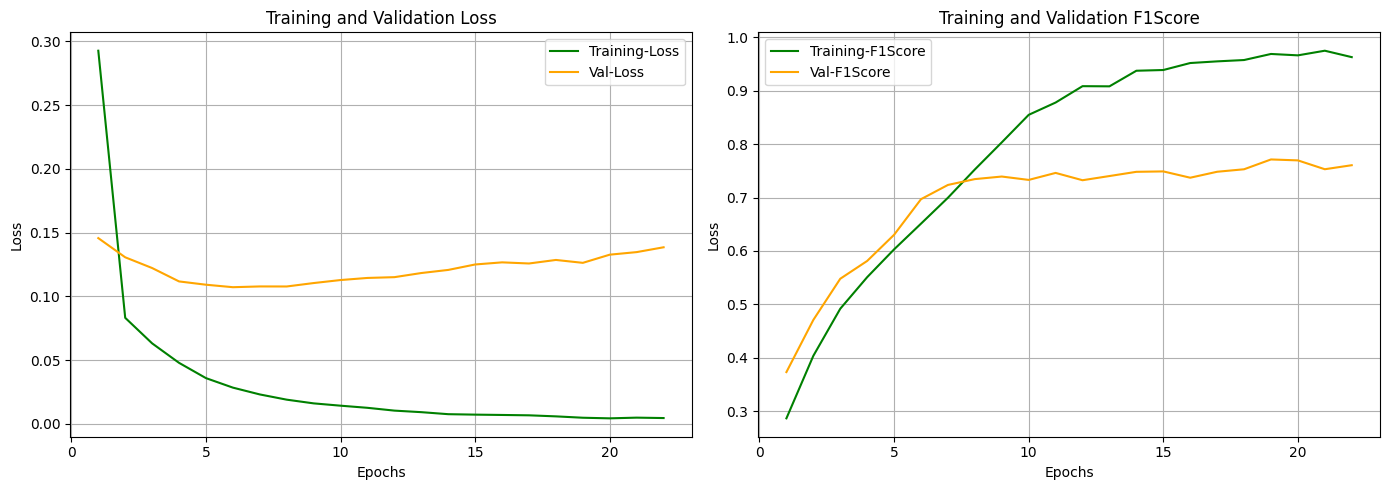

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9869 - loss: 0.1316
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.67


In [50]:
transf_tests.append("more_heads_8")
num_heads = 8
model_transf_3 = Sequential()
model_transf_3.add(TokenAndPositionEmbedding(train_pad_sequences.shape[1], vocab_size, best_emb))
model_transf_3.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_3.add(Dense(128, activation='relu'))
model_transf_3.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_transf_3, epochs, batch_size)
f1_score_train_transf.append(last_f1_train)
f1_score_val_transf.append(best_f1)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Epoch 1: F1-Score Macro Train= 0.2821, F1-Score Macro Val = 0.3644
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.8908 - loss: 0.6742 - val_accuracy: 0.9668 - val_loss: 0.1448
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.4005, F1-Score Macro Val = 0.4860
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.9722 - loss: 0.0894 - val_accuracy: 0.9703 - val_loss: 0.1302
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 3: F1-Score Macro Train= 0.4801, F1-Score Macro Val = 0.5507
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9767 - loss: 0.0669 - val_accuracy: 0.9747 - val_loss: 0.1217
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Epoch 4: F1-Score Macro Train= 0.5482, F1-Score Macro Val = 0.5927
128/128 

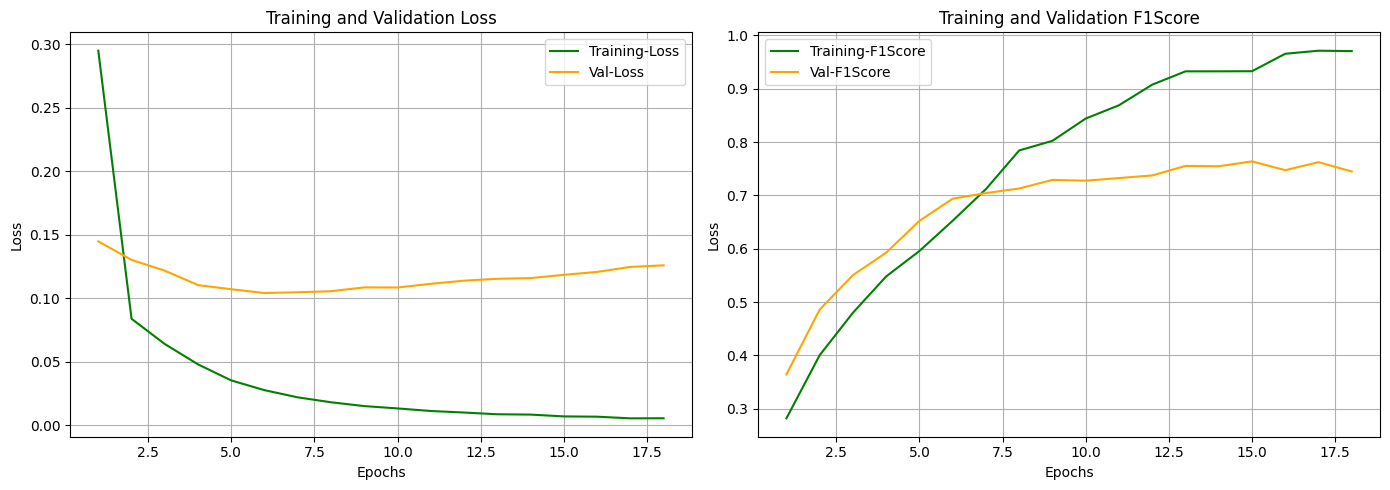

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.9872 - loss: 0.1207
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.70


In [51]:
transf_tests.append("more_heads_12")
num_heads = 12
model_transf_4 = Sequential()
model_transf_4.add(TokenAndPositionEmbedding(train_pad_sequences.shape[1], vocab_size, best_emb))
model_transf_4.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_4.add(Dense(128, activation='relu'))
model_transf_4.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_transf_4, epochs, batch_size)
f1_score_train_transf.append(last_f1_train)
f1_score_val_transf.append(best_f1)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

Epoch 1: F1-Score Macro Train= 0.2537, F1-Score Macro Val = 0.3146
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 209ms/step - accuracy: 0.8814 - loss: 0.7584 - val_accuracy: 0.9660 - val_loss: 0.1537
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.3888, F1-Score Macro Val = 0.4733
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9733 - loss: 0.0962 - val_accuracy: 0.9769 - val_loss: 0.1221
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 3: F1-Score Macro Train= 0.4704, F1-Score Macro Val = 0.5380
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9836 - loss: 0.0585 - val_accuracy: 0.9806 - val_loss: 0.1115
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 4: F1-Score Macro Train= 0.5486, F1-Score Macro Val = 0.5977
128/12

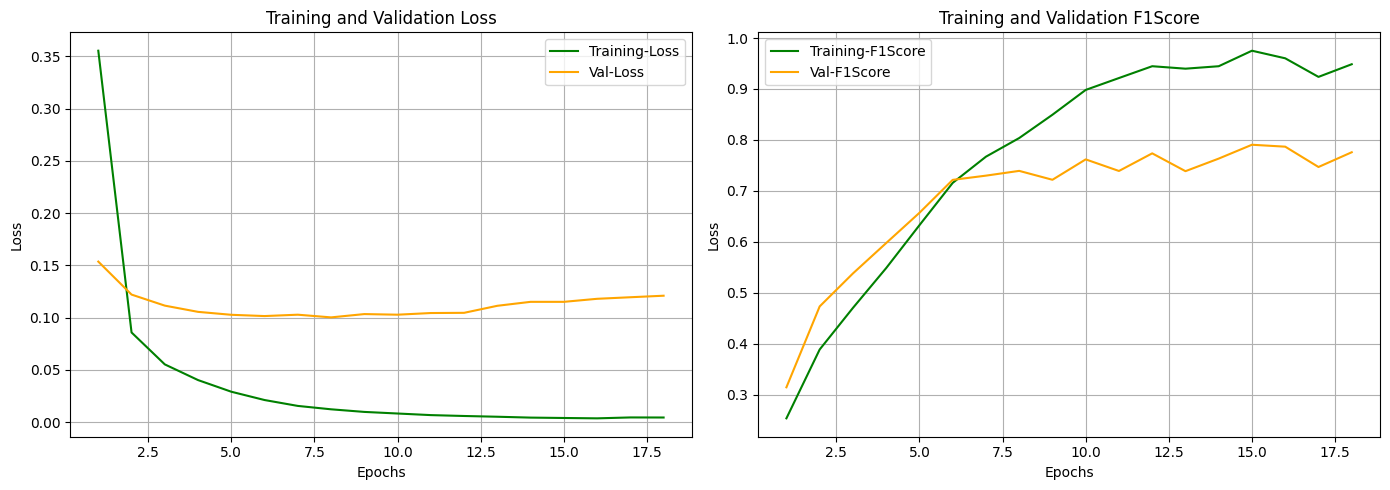

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9888 - loss: 0.1131
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.71


In [52]:
transf_tests.append("more_layers_3")
num_heads = 6
model_transf_5 = Sequential()
model_transf_5.add(TokenAndPositionEmbedding(train_pad_sequences.shape[1], vocab_size, best_emb))
model_transf_5.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_5.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_5.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_5.add(Dense(128, activation='relu'))
model_transf_5.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_transf_5, epochs, batch_size)
f1_score_train_transf.append(last_f1_train)
f1_score_val_transf.append(best_f1)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

Epoch 1: F1-Score Macro Train= 0.1712, F1-Score Macro Val = 0.2317
128/128 ━━━━━━━━━━━━━━━━━━━━ 82s 369ms/step - accuracy: 0.8554 - loss: 0.9157 - val_accuracy: 0.9626 - val_loss: 0.1758
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Epoch 2: F1-Score Macro Train= 0.3516, F1-Score Macro Val = 0.4377
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.9708 - loss: 0.1132 - val_accuracy: 0.9788 - val_loss: 0.1227
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Epoch 3: F1-Score Macro Train= 0.4560, F1-Score Macro Val = 0.5201
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9849 - loss: 0.0588 - val_accuracy: 0.9827 - val_loss: 0.1089
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Epoch 4: F1-Score Macro Train= 0.5583, F1-Score Macro Val = 0.6339
12

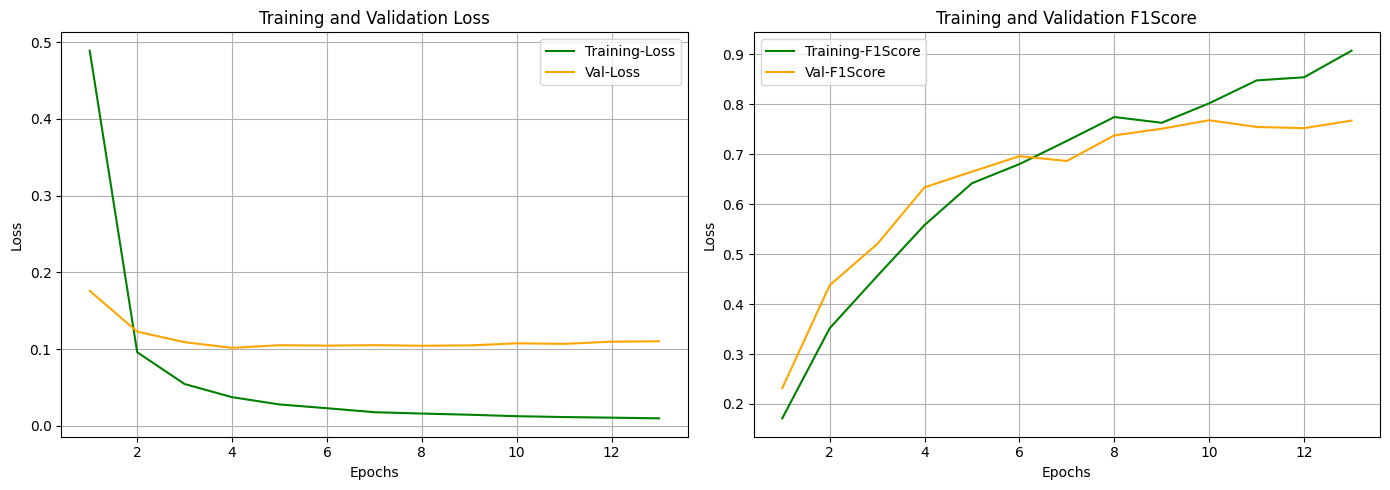

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.9876 - loss: 0.1050
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.70


In [53]:
transf_tests.append("more_layers_6")
num_heads = 6
model_transf_6 = Sequential()
model_transf_6.add(TokenAndPositionEmbedding(train_pad_sequences.shape[1], vocab_size, best_emb))
model_transf_6.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_6.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_6.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_6.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_6.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_6.add(TransformerBlock(best_emb, num_heads, ff_dim))
model_transf_6.add(Dense(128, activation='relu'))
model_transf_6.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_transf_6, epochs, batch_size)
f1_score_train_transf.append(last_f1_train)
f1_score_val_transf.append(best_f1)

In [54]:
results_transf = {'experiment': transf_tests, 'f1_score_train': f1_score_train_transf, 'f1_score_val': f1_score_val_transf}
pd.DataFrame(results_transf)

,experiment,f1_score_train,f1_score_val
0,basic,0.907312,0.762910
1,more_heads_6,0.908718,0.760920
2,more_heads_8,0.968842,0.771324
3,more_heads_12,0.932942,0.763892
4,more_layers_3,0.975109,0.790584
5,more_layers_6,0.802159,0.768208


## Regularització

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 1: F1-Score Macro Train= 0.0179, F1-Score Macro Val = 0.0251
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8727 - loss: 1.0996 - val_accuracy: 0.9349 - val_loss: 0.3227
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 2: F1-Score Macro Train= 0.0732, F1-Score Macro Val = 0.0994
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9452 - loss: 0.2536 - val_accuracy: 0.9592 - val_loss: 0.2157
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 3: F1-Score Macro Train= 0.1509, F1-Score Macro Val = 0.2107
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9667 - loss: 0.1425 - val_accuracy: 0.9717 - val_loss: 0.1831
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 4: F1-Score Macro Train= 0.2764, F1-Score Macro Val = 0.3271
128/128 ━

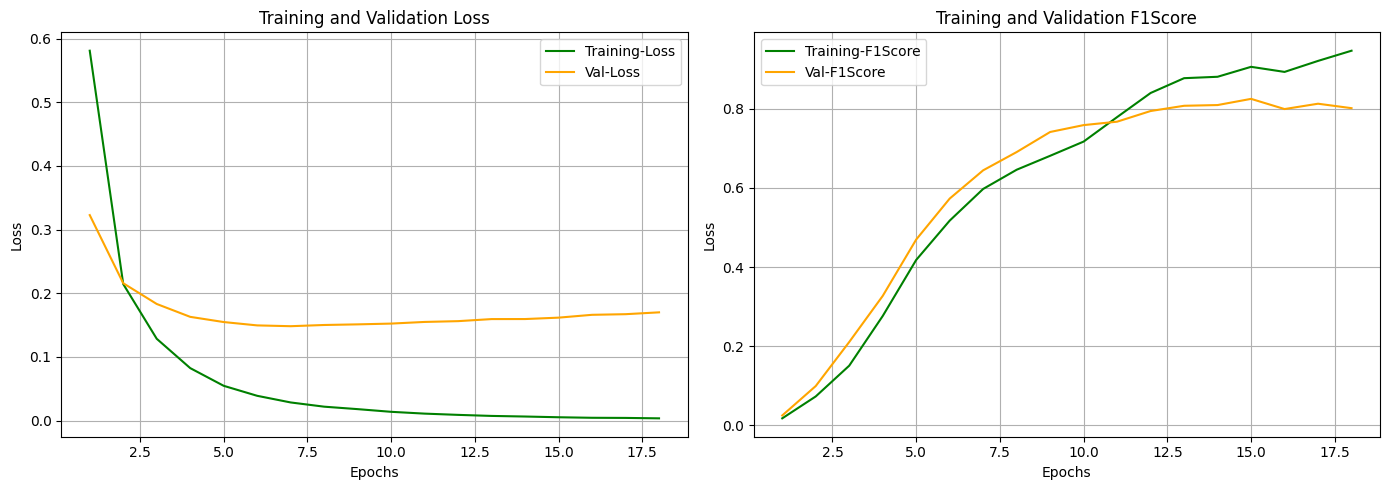

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9901 - loss: 0.1501
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.71


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 1: F1-Score Macro Train= 0.0172, F1-Score Macro Val = 0.0245
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.8726 - loss: 1.1065 - val_accuracy: 0.9327 - val_loss: 0.3335
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0638, F1-Score Macro Val = 0.0881
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9436 - loss: 0.2625 - val_accuracy: 0.9576 - val_loss: 0.2259
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Epoch 3: F1-Score Macro Train= 0.1331, F1-Score Macro Val = 0.1888
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9653 - loss: 0.1485 - val_accuracy: 0.9704 - val_loss: 0.1958
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 4: F1-Score Macro Train= 0.2726, F1-Score Macro Val = 0.3421
128/128 ━━

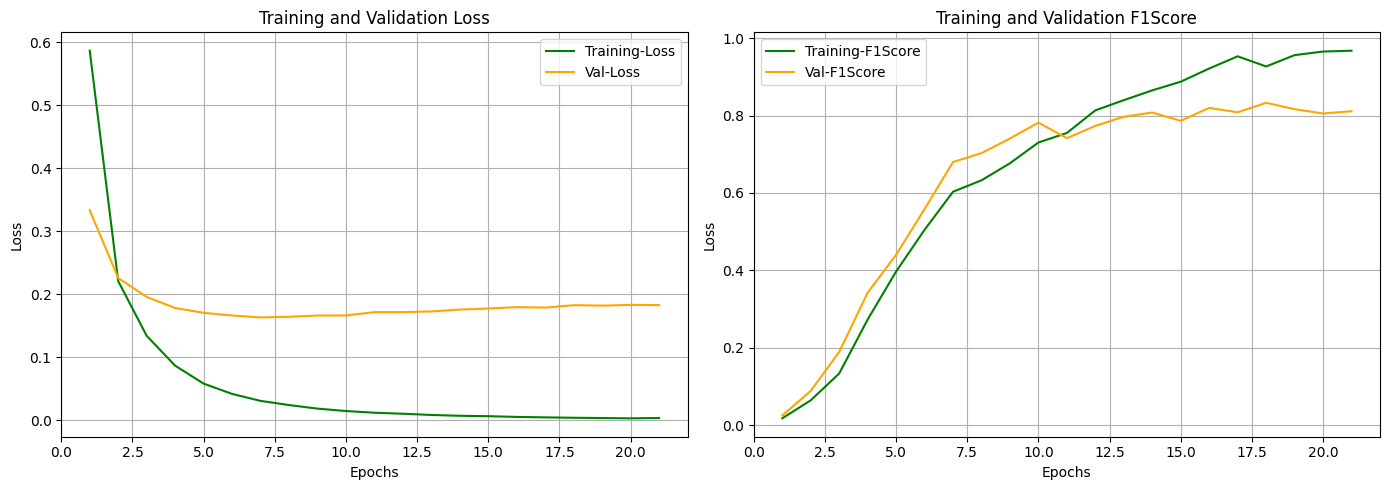

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9900 - loss: 0.1670
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.74


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 1: F1-Score Macro Train= 0.0172, F1-Score Macro Val = 0.0244
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8725 - loss: 1.1119 - val_accuracy: 0.9327 - val_loss: 0.3294
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 2: F1-Score Macro Train= 0.0622, F1-Score Macro Val = 0.0871
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9436 - loss: 0.2606 - val_accuracy: 0.9578 - val_loss: 0.2261
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Epoch 3: F1-Score Macro Train= 0.1370, F1-Score Macro Val = 0.2038
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9646 - loss: 0.1497 - val_accuracy: 0.9703 - val_loss: 0.1982
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 4: F1-Score Macro Train= 0.2635, F1-Score Macro Val = 0.3237
128/128 ━

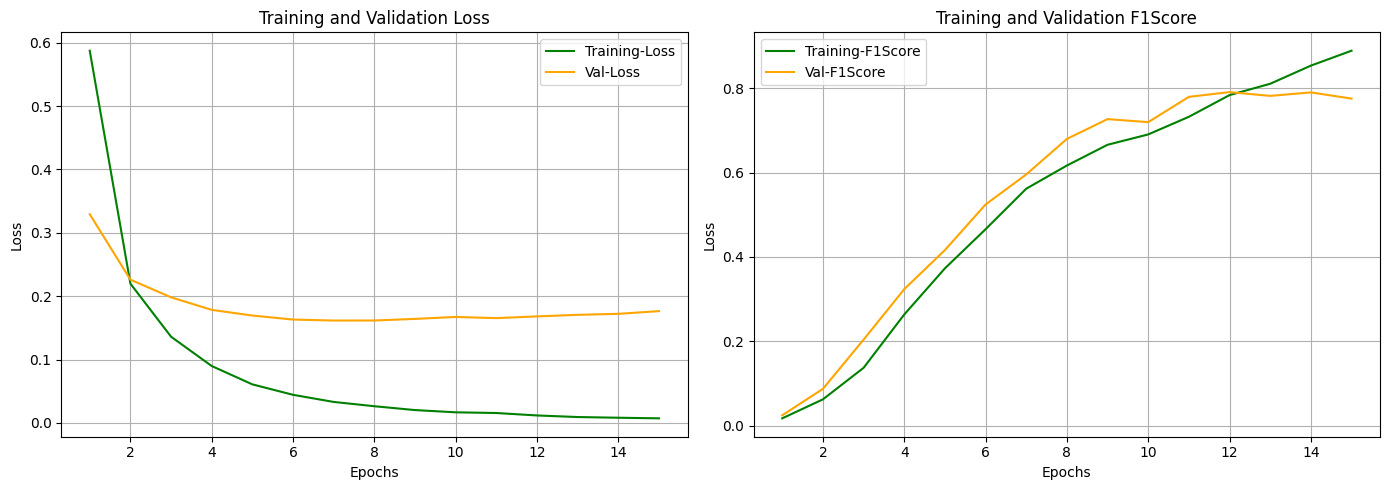

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9902 - loss: 0.1502
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.71


In [55]:
prob_dropout = [0.1, 0.2, 0.3]
models_dropout = [f'model_dropout_{i}' for i in prob_dropout]
dropout_tests = [f'dropout_{i}' for i in prob_dropout]
f1_score_train_dropout = []
f1_score_val_dropout = []

for i, prob in enumerate(prob_dropout):
    models_dropout[i] = Sequential()
    models_dropout[i].add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
    models_dropout[i].add(Dropout(prob))
    models_dropout[i].add(Bidirectional(LSTM(units=256, return_sequences=True)))
    models_dropout[i].add(Dense(128, activation='relu'))
    models_dropout[i].add(Dense(num_unique_entities, activation='softmax'))
    last_f1_train, best_f1 = run_model(models_dropout[i], epochs, batch_size)
    f1_score_train_dropout.append(last_f1_train)
    f1_score_val_dropout.append(best_f1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 1: F1-Score Macro Train= 0.0161, F1-Score Macro Val = 0.0225
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.8716 - loss: 1.2018 - val_accuracy: 0.9292 - val_loss: 0.3504
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Epoch 2: F1-Score Macro Train= 0.0528, F1-Score Macro Val = 0.0738
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9418 - loss: 0.2767 - val_accuracy: 0.9568 - val_loss: 0.2308
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 3: F1-Score Macro Train= 0.1270, F1-Score Macro Val = 0.1675
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9639 - loss: 0.1525 - val_accuracy: 0.9704 - val_loss: 0.2029
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Epoch 4: F1-Score Macro Train= 0.2708, F1-Score Macro Val = 0.3157
128/128 ━

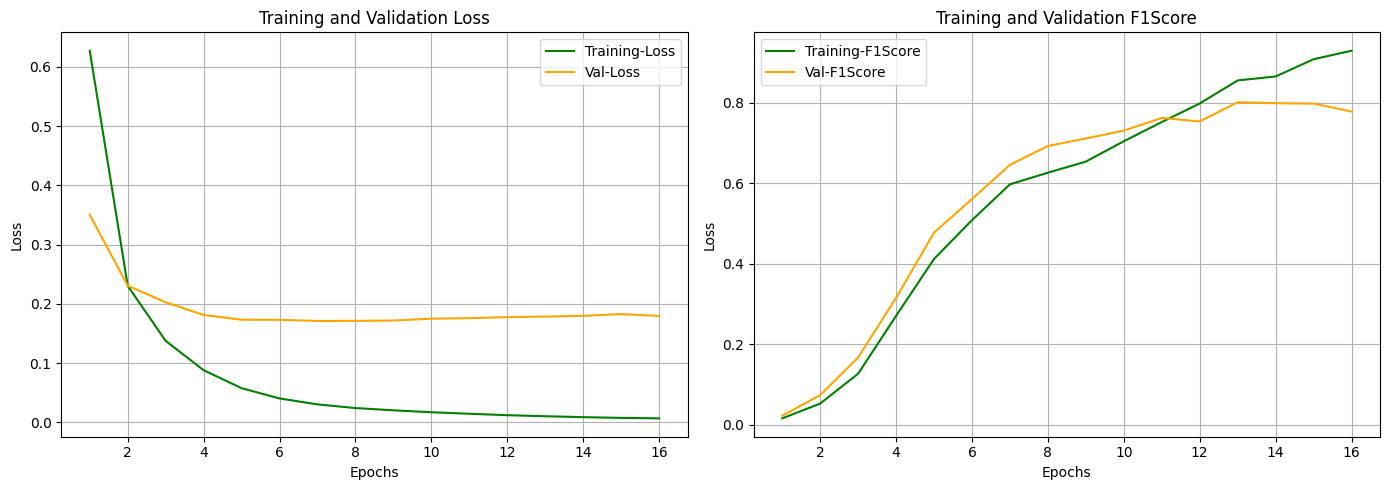

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9897 - loss: 0.1625
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Test accuracy: 0.99, F1-Score Macro Test: 0.71


In [56]:
prob = prob_dropout[np.argmax(f1_score_val_dropout)]
dropout_tests.append("more_layer")
model_dropout = Sequential()
model_dropout.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_dropout.add(Dropout(prob))
model_dropout.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model_dropout.add(Dropout(prob))
model_dropout.add(Dense(128, activation='relu'))
model_dropout.add(Dense(num_unique_entities, activation='softmax'))
last_f1_train, best_f1 = run_model(model_dropout, epochs, batch_size)
f1_score_train_dropout.append(last_f1_train)
f1_score_val_dropout.append(best_f1)

In [57]:
results_dropout = {'experiment': dropout_tests, 'f1_score_train': f1_score_train_dropout, 'f1_score_val': f1_score_val_dropout}
pd.DataFrame(results_dropout)

,experiment,f1_score_train,f1_score_val
0,dropout_0.1,0.905985,0.825029
1,dropout_0.2,0.926984,0.833023
2,dropout_0.3,0.784107,0.791167
3,more_layer,0.855630,0.801430


## Balancejat de les classes

In [22]:
# Pas 1: Aplanar les etiquetes per utilitzar-les amb compute_class_weight
train_labels_flat = np.argmax(train_labels_one_hot, axis=-1).flatten()  # Convertir de one-hot a etiquetas y luego aplanar

# Pas 2: Calcular els pesos de les classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_flat),
    y=train_labels_flat
)

# Crear un diccionari de pesos per pasar-lo a Keras
class_weights_dict = {i: weight for i, weight in zip(np.unique(train_labels_flat), class_weights)}

print("Pesos de les classes:", class_weights_dict)

def weighted_categorical_crossentropy(y_true, y_pred):
    """
    Función de pérdida personalizada para aplicar class weights en tareas NER.
    """
    weights = tf.constant([class_weights_dict.get(i, 1.0) for i in range(num_unique_entities)])
    y_true_classes = tf.argmax(y_true, axis=-1)  # Convertir one-hot a etiquetas de clase
    y_true_weights = tf.gather(weights, y_true_classes)  # Obtener el peso de cada clase

    # Calcular la pérdida categórica y multiplicar por los pesos
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = loss * y_true_weights
    return tf.reduce_mean(weighted_loss)

Pesos de les classes: {0: 58.384064737005914, 1: 13.82780480613298, 2: 2.7415126050420167, 3: 75.06522609043617, 4: 47.768780239368475, 5: 157.63697478991597, 6: 22.519567827130853, 7: 39.40924369747899, 8: 39.40924369747899, 9: 1576.3697478991596, 10: 105.09131652661064, 11: 525.4565826330532, 12: 31.527394957983194, 13: 98.52310924369748, 14: 8.856009819658201, 15: 9.79111644657863, 16: 8.90604377344158, 17: 8.90604377344158, 18: 47.768780239368475, 19: 5.774248160802783, 20: 315.27394957983194, 21: 788.1848739495798, 22: 525.4565826330532, 23: 24.251842275371686, 24: 2.1159325475156505, 25: 4.988511860440378, 26: 5.202540422109438, 27: 23.884390119684237, 28: 71.65317035905271, 29: 71.65317035905271, 30: 54.35757751376413, 31: 3.2105290181245616, 32: 71.65317035905271, 33: 5.134754879150357, 34: 5.816862538373283, 35: 50.85063702900515, 36: 33.539781870194886, 37: 24.63077731092437, 38: 49.26155462184874, 39: 5.732253628724217, 40: 24.63077731092437, 41: 11.259783913565427, 42: 25.8

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Epoch 1: F1-Score Macro Train= 0.0378, F1-Score Macro Val = 0.0409
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7449 - loss: 4.7227 - val_accuracy: 0.7687 - val_loss: 4.6696
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Epoch 2: F1-Score Macro Train= 0.1538, F1-Score Macro Val = 0.1705
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.7799 - loss: 3.9631 - val_accuracy: 0.7962 - val_loss: 3.4998
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step

Epoch 3: F1-Score Macro Train= 0.3414, F1-Score Macro Val = 0.3116
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.8059 - loss: 2.4802 - val_accuracy: 0.8174 - val_loss: 2.7229
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Epoch 4: F1-Score Macro Train= 0.3875, F1-Score Macro Val = 0.3476

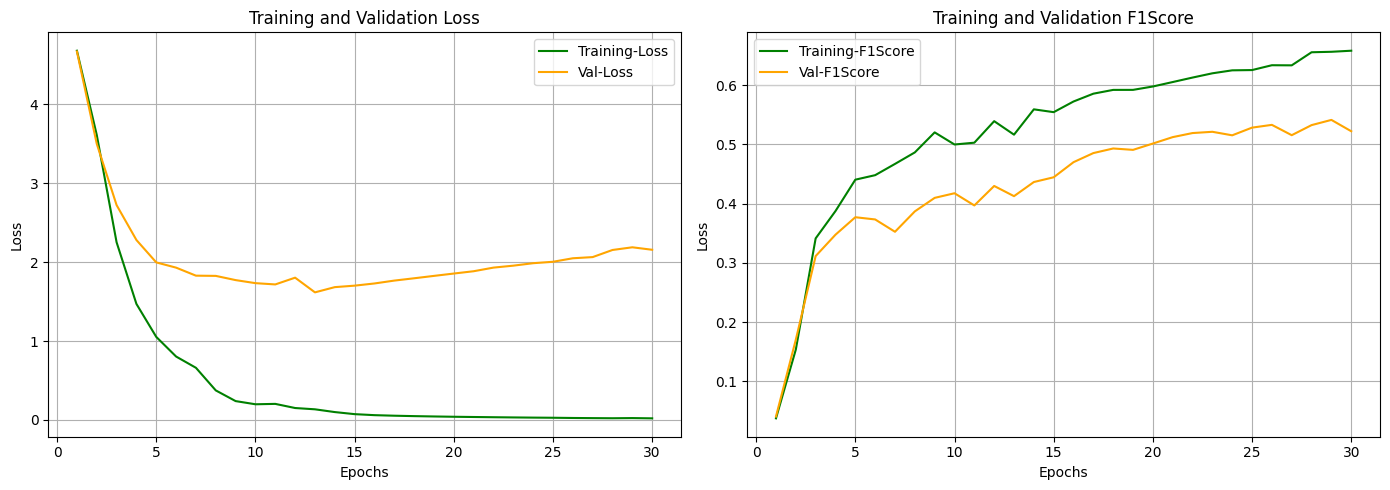

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9309 - loss: 7.2039
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test accuracy: 0.93, F1-Score Macro Test: 0.46


In [23]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

#TODO
embedding_dim = 100
vocab_size = num_words + 1
batch_size = 32
epochs = 30

model_weighted = Sequential()
model_weighted.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)) #layer 1
model_weighted.add(LSTM(units=64, return_sequences=True))
model_weighted.add(Dense(128, activation='relu'))
model_weighted.add(Dense(num_unique_entities, activation='softmax'))
_, _ = run_model(model_weighted, epochs, batch_size, weigthed=True, weighted_categorical_crossentropy = weighted_categorical_crossentropy)

In [58]:
labels_idx = preds_to_index(val_labels_one_hot,len_val_sequences)
preds = model_weighted.predict(val_pad_sequences)
preds_idx = preds_to_index(preds, len_val_sequences)
report = classification_report(labels_idx, preds_idx, zero_division=1.0, output_dict=True)
f1_scores = [report[str(cls)]['f1-score'] for cls in range(num_unique_entities) if str(cls) in report.keys()]
class_weights_used = [weight for i, weight in class_weights_dict.items() if str(i) in report.keys()]
class_weights_used_scaled = (class_weights_used - np.min(class_weights_used)) / (np.max(class_weights_used) - np.min(class_weights_used))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


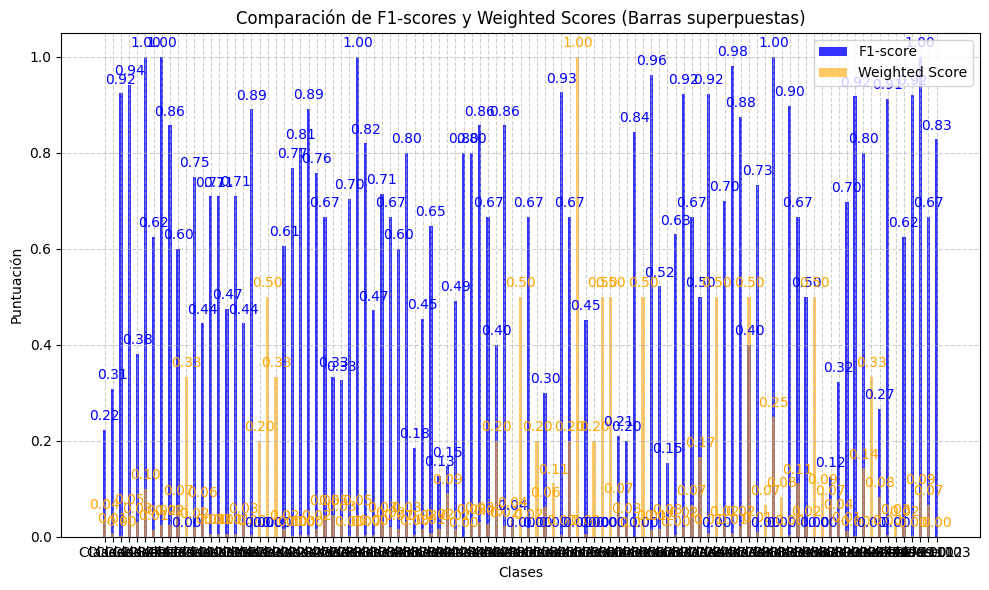

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Ejemplos de listas
weighted = class_weights_used_scaled

# Nombres de las clases (puedes personalizar según tus necesidades)
clases = [f'Clase {i}' for i in range(1, len(f1_scores) + 1)]

# Definir la posición de las barras
x = np.arange(len(clases))

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de barras para F1-scores (barra principal)
ax.bar(x, f1_scores, width=0.4, label='F1-score', color='blue', alpha=0.8)

# Gráfico de barras para weighted scores (barra superpuesta)
ax.bar(x, weighted, width=0.4, label='Weighted Score', color='orange', alpha=0.6)

# Añadir etiquetas y título
ax.set_xlabel('Clases')
ax.set_ylabel('Puntuación')
ax.set_title('Comparación de F1-scores y Weighted Scores (Barras superpuestas)')
ax.set_xticks(x)
ax.set_xticklabels(clases)
ax.legend()

# Añadir las etiquetas con los valores en las barras
for i in range(len(f1_scores)):
    ax.text(x[i], f1_scores[i] + 0.02, f'{f1_scores[i]:.2f}', ha='center', color='blue')
    ax.text(x[i], weighted[i] + 0.02, f'{weighted[i]:.2f}', ha='center', color='orange')

# Mostrar la gráfica
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Conclusió

In [76]:
pd.DataFrame(results_conv)

,experiment,f1_score_train,f1_score_val
0,basic,0.731246,0.676018
1,more_filters_512,0.579052,0.666804
2,less_filters_128,0.629499,0.663865
3,more_layers_1,0.871662,0.700237
4,more_layers_2,0.919996,0.782655
5,kernel_size_5,0.926330,0.764104
6,kernel_size_7,0.911162,0.744866


In [77]:
pd.DataFrame(results_rnn)

,experiment,f1_score_train,f1_score_val
0,basic,0.949319,0.819496
1,lstm_more_units_128,0.920266,0.830580
2,lstm_more_units_256,0.936398,0.807753
3,gru_more_units_128,0.927529,0.804012
4,gru_more_units_256,0.963936,0.839430
5,lstm_bidirec,0.987085,0.823044
6,gru_bidirect,0.732276,0.820886


In [78]:
pd.DataFrame(results_transf)

,experiment,f1_score_train,f1_score_val
0,basic,0.907312,0.762910
1,more_heads_6,0.908718,0.760920
2,more_heads_8,0.968842,0.771324
3,more_heads_12,0.932942,0.763892
4,more_layers_3,0.975109,0.790584
5,more_layers_6,0.802159,0.768208


In [79]:
pd.DataFrame(results_dropout)

,experiment,f1_score_train,f1_score_val
0,dropout_0.1,0.905985,0.825029
1,dropout_0.2,0.926984,0.833023
2,dropout_0.3,0.784107,0.791167
3,more_layer,0.855630,0.801430


Prediu bé les classes que tenen més exemples. Ha pujat significament f1-score mantenint accuracy alta a la vegada.

In [85]:
best_model = model_dropout
preds = best_model.predict(test_pad_sequences)
test_labels_idx = preds_to_index(test_labels_one_hot,len_test_sequences)
preds_idx = preds_to_index(preds, len_test_sequences)

print(classification_report(test_labels_idx, preds_idx, zero_division=1.0))

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       1.00      0.62      0.77        24
           1       1.00      0.90      0.95        29
           2       0.96      0.97      0.97        79
           3       1.00      0.00      0.00         8
           4       0.89      0.44      0.59        18
           5       1.00      1.00      1.00         1
           6       0.64      1.00      0.78         7
           7       0.67      0.67      0.67         3
           8       0.67      0.67      0.67         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         3
          14       0.85      0.85      0.85        13
          15       0.92      0.86      0.89        14
          16       0.85      0.65      0.74        43
          17       1.00      1.00      1.00        24
          18       0.86      1.00      0.92         6
          19       1.00      1.00      1.0

---

<h1><a name="section-four"> 4. Lliurable </a></h1>

Heu d'entregar un document PDF de com a **màxim 10 pàgines** que incloga els resultats de tots els exercicis així com una explicació de cadascun dels resultats i de la modificació que heu fet. L'estructura del document és:

1. Introducció.
2. Experiments i Resultats (amb raonament).
3. Conclusions.

No cal que afegiu el vostre codi al document, podeu entregar el *notebook* juntament amb el document.

 ---